# Parte 2

A segunda parte do trabalho pretende cimentar os conhecimentos de pandas terminando a pipeline de DS.

A estrutura deste notebook e dos módulos de python já se encontra definida. Apenas terão de:

1. completar funções ou parte de código;
2. implementar a totalidade do código numa **única** célula de forma a responder a uma pergunta.

**Nota**: se vos for mais conveniente poderão alterar a estrutura dos módulos e / ou notebook. Se assim o quiserem, por favor, adicionem comentários esclarecedores relativos a cada parte de forma a eu não cometer erros na avaliação.

<p>
  <div class="alert alert-success">
    Todas as perguntas estarão assinaladas com este fundo verde.
  </div>
</p>

<p>
  <div class="alert alert-info">
    Notem que durante o notebook irão encontrar o comando <a href="https://wiki.python.org/moin/UsingAssertionsEffectively">assert</a> várias vezes. Este comando permite verificar se duas expressões têm o mesmo valor. Irei usá-lo para confirmar que certos valores estão correctos. <span class="badge">Caso algum dê erro, venham falar comigo.</span>
  </div>
</p>

O índice da segunda parte é o seguinte:

**1. Continuar data understanding** <br>
- 1.1 Dados de voos
- 1.2 Análise temporal
- 1.3 Considerando informação de contexto

**2. Gerar dataset histórico, de treino e de teste** <br>
- 2.1 Motivação
- 2.2 Construção dos datasets

**3. Feature Engineering** <br>
- 3.1 Usando dados históricos
- 3.2 Novos campos temporais
- 3.3 Risky features e OHE
- 3.4 Normalizar colunas
- 3.5 Outras colunas
- 3.6 Remover colunas desnecessárias

**4. Construir regressão logística** <br>
- 4.1 Treino do modelo
- 4.2 Construir matriz de confusão
- 4.3 Avaliar performance do modelo

___

Vamos começar por carregar todas as dependências que podemos vir a usar. 

In [91]:
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import sqlite3
from bs4 import BeautifulSoup

from os import listdir
from os.path import isfile, join

# inline matplotlib plots
%matplotlib inline

try:
    # https://plot.ly/python/offline/
    import plotly.offline as py
    # inline plotly plots
    py.init_notebook_mode(connected=True)
except:
    pass

# all pandas prints will have this format
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option("display.max_columns", 40)
pd.set_option('display.max_rows', 200)

# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
# http://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
plt.rcParams['figure.figsize'] = 10, 6  # default image size

___
### 1. Continuar data understanding
___

Por ser um notebook diferente, temos de voltar a carregar os datasets em memória.

In [93]:
import os
from utilities import read_flights_data

path = join(os.getcwd(), 'data')

airlines = pd.read_csv(join(path, 'airlines.csv'))
airports = pd.read_csv(join(path, 'airports.csv'))
flights = read_flights_data(join(path, 'flights_until_june.csv'))

# confirm number of rows and columns per dataset
assert airlines.shape == (14, 2)
assert airports.shape == (322, 7)
assert flights.shape == (2889512, 31)
print('Airlines:', airlines.shape)
print('Airports:', airports.shape)
print(' Flights:', flights.shape)

Airlines: (14, 2)
Airports: (322, 7)
 Flights: (2889512, 31)


Antes de começar o DU vamos remover algumas colunas que não serão usadas.

In [94]:
columns_to_remove = 'flight_number day_of_week tail_number departure_time taxi_out wheels_off wheels_on taxi_in scheduled_arrival arrival_time diverted'.split()

flights.drop(columns_to_remove, inplace=True, axis=1)

In [95]:
flights.head()

,year,month,day,airline,origin_airport,destination_airport,scheduled_departure,departure_delay,scheduled_time,elapsed_time,air_time,distance,arrival_delay,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
0,2015,1,1,AS,ANC,SEA,5.000,-11.000,205.000,194.000,169.000,1448,-22.000,False,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,AA,LAX,PBI,10.000,-8.000,280.000,279.000,263.000,2330,-9.000,False,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,US,SFO,CLT,20.000,-2.000,286.000,293.000,266.000,2296,5.000,False,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,AA,LAX,MIA,20.000,-5.000,285.000,281.000,258.000,2342,-9.000,False,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,AS,SEA,ANC,25.000,-1.000,235.000,215.000,199.000,1448,-21.000,False,NaN,NaN,NaN,NaN,NaN,NaN


Na primeira parte do trabalho definimos a coluna `is_delayed` e a função `convert_to_time_format`. Na próxima célula cole o código necessário para as criar, pois estas serão usadas ao longo deste notebook.

<span class="badge">Nota:</span> Senão conseguiu definir alguma delas entre em contacto com o formador.

In [96]:
# add field is_delayed
flights['is_delayed'] = flights['arrival_delay'] >= 15
flights

,year,month,day,airline,origin_airport,destination_airport,scheduled_departure,departure_delay,scheduled_time,elapsed_time,air_time,distance,arrival_delay,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,is_delayed
0,2015,1,1,AS,ANC,SEA,5.000,-11.000,205.000,194.000,169.000,1448,-22.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False
1,2015,1,1,AA,LAX,PBI,10.000,-8.000,280.000,279.000,263.000,2330,-9.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False
2,2015,1,1,US,SFO,CLT,20.000,-2.000,286.000,293.000,266.000,2296,5.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False
3,2015,1,1,AA,LAX,MIA,20.000,-5.000,285.000,281.000,258.000,2342,-9.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False
4,2015,1,1,AS,SEA,ANC,25.000,-1.000,235.000,215.000,199.000,1448,-21.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2889507,2015,6,30,UA,LAX,ORD,"2,359.000",-1.000,241.000,234.000,218.000,1744,-8.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False
2889508,2015,6,30,UA,LAX,IAH,"2,359.000",90.000,201.000,190.000,172.000,1379,79.000,False,NaN,0.000,0.000,21.000,58.000,0.000,True
2889509,2015,6,30,UA,PDX,IAH,"2,359.000",113.000,249.000,243.000,214.000,1825,107.000,False,NaN,0.000,0.000,0.000,107.000,0.000,True
2889510,2015,6,30,UA,SEA,IAH,"2,359.000",13.000,250.000,246.000,221.000,1874,9.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False


In [97]:
def convert_to_time_format(x):
    """
    Converts a number (1234) that represents a hour to a string with 
    hour format, e.g. 12:34
    
    Parameters:
    ----------
    x : float
        hour as float
    """
  
    # Se o valor for NaN dá uma string vazia
    if pd.isna(x): 
        return ""
    
    # Extrai as horas e os minutos      
    hours = int (x // 100)
    minutes = int (x % 100)
    
    # Assegura que as horas e os minutos estão dentro dos limites (0-23 horas e 0-59 minutos)
    hours = hours % 24
    minutes = minutes % 60
    
    # Dá a hora e os minutos no formato desejado
    time = f"{hours:02d}:{minutes:02d}"
    
    return time

assert convert_to_time_format(5) == '00:05'
assert convert_to_time_format(5.0) == '00:05'
assert convert_to_time_format(130) == '01:30'
assert convert_to_time_format(2400) == '00:00'

#### 1.1 Dados de voos

Como complemento ao data understanding (DU) realizador na primeira parte do trabalho, vamos começar por coletar insights sobre o atraso do voos.

Como se observou na primeira parte do trabalho, os atrasos variam imenso de companhia aéra para companhia aérea. Assim sendo, vamos analisar um pouco mais esta questão de voos atrasados. Afinal, é isso que queremos prever com a regressão logística.

Se repararem, para os voos com atraso, temos detalhado nas colunas `airline_delay`, `late_aircraft_delay`, `air_system_delay`, `security_delay` e `weather_delay` o tempo de atraso associado com cada uma deste motivos.

<div class="alert alert-success">
Q.1 <br>
Vamos começar por calcular a média de cada um destes atrasos (apenas para os voos com atraso).
</div>

In [98]:
# delay's average

avg_airline_delay = flights['airline_delay'].mean()
avg_late_aircraft_delay = flights['late_aircraft_delay'].mean()
avg_air_system_delay = flights['air_system_delay'].mean()
avg_security_delay = flights['security_delay'].mean()
avg_weather_delay = flights['weather_delay'].mean()

print("Average Airline Delay:", avg_airline_delay)
print("Average Late Aircraft Delay:", avg_late_aircraft_delay)
print("Average Air System Delay:", avg_air_system_delay)
print("Average Security Delay:", avg_security_delay)
print("Average Weather Delay:", avg_weather_delay)

Average Airline Delay: 18.624249
Average Late Aircraft Delay: 23.530634
Average Air System Delay: 13.687651
Average Security Delay: 0.05977019
Average Weather Delay: 3.207603


<div class="alert alert-success">
Q.2<br>
    Considerando apenas os aeroportos de partida, calcule o top-10 com mais voos atrasados (em percentagem).
</div>

In [99]:
# top-10 delayed origin_airport
# Voos atrasados 
delayed_flights = flights[flights['is_delayed']]

# média dos voos atrasados por aeroporto de origem
delayed_flights = flights.groupby("origin_airport")["is_delayed"].mean() * 100

#Ordenar por ordem decrescente 
delayed_flights_order = delayed_flights.sort_values(ascending = False)

# Obter o top 10 de voos atrasados
top_10_delayed_flights = delayed_flights_order.head(10)

top_10_delayed_flights

origin_airport
PPG   38.182
GST   37.500
ILG   37.000
ADK   34.615
PBG   32.075
MEI   29.735
BPT   29.291
STC   28.916
GGG   27.350
TTN   27.298
Name: is_delayed, dtype: float64

O aeroporto de partida com mais voos atrasados é o <a href="https://en.wikipedia.org/wiki/Pago_Pago_International_Airport">PPG</a>. 
<div class="alert alert-success">
Q.3<br>
    Pare este aeroporo, calcule o número de voos que partem por mês.
</div>

In [100]:
# montly flights from PPG airport

# voos que saem do aeroporto PPG
airport_flights = flights[flights["origin_airport"] == "PPG"]

# Calcular o número de voos que saem daquele aeroporto por mês
flights_per_month = airport_flights["month"].value_counts().sort_index()

# Ordenar o número de voos
flights_per_month

1    10
2     8
3     9
4     8
5     9
6    11
Name: month, dtype: int64

Em suma, apesar de ter uma grande percentagem de voos atrasados, parecendo indicar ser um bom aeroporto para nos focarmos na análise, este representa apenas uma pequena percentagem de todos os voos. Dessa forma, acabando por não ter significância para as nossas análises.
<br><br>
<div class="alert alert-success">
Q.4<br>
    Para <b>voos cancelados</b>, apresente um plot - à sua escolha - com a distribuição da coluna <code>cancellation_reason</code>.
</div>

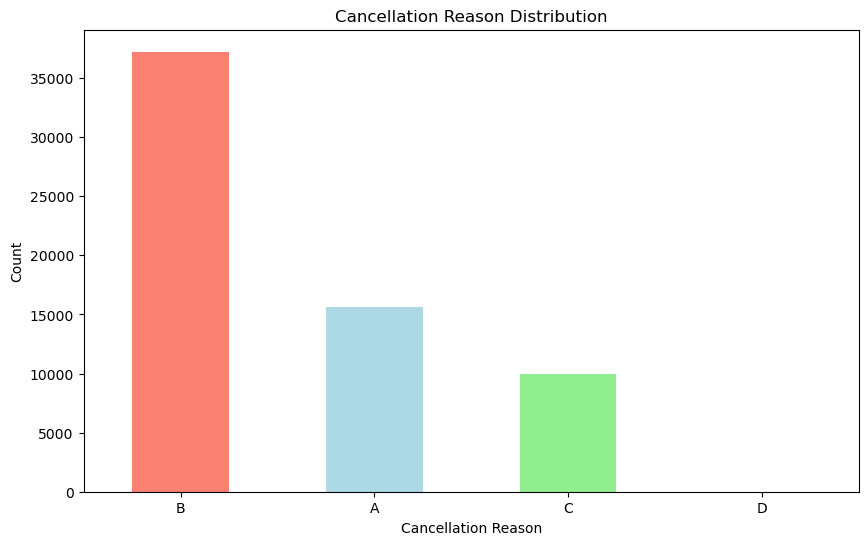

In [101]:
# cancellation_reason distribution plot
cancellation_reason = flights['cancellation_reason'].value_counts()

# Construção do Gráfico de Barras
cancellation_reason.plot(kind="bar", color=["salmon", "lightblue", "lightgreen", "yellow"])
plt.xlabel('Cancellation Reason')
plt.ylabel('Count')
plt.title('Cancellation Reason Distribution')
plt.xticks(rotation = 0)
plt.show()

De seguida iremos analisar, para cada companhia aérea, a percentagem de voos cancelados.
<br><br>
<div class="alert alert-success">
Q.5 <br>
    Construa o dataframe <code>g</code>, onde para cada <code>airline</code> tem uma coluna com o número de voos cancelados e uma coluna com o total de voos.
</div>

<AxesSubplot:xlabel='airline'>

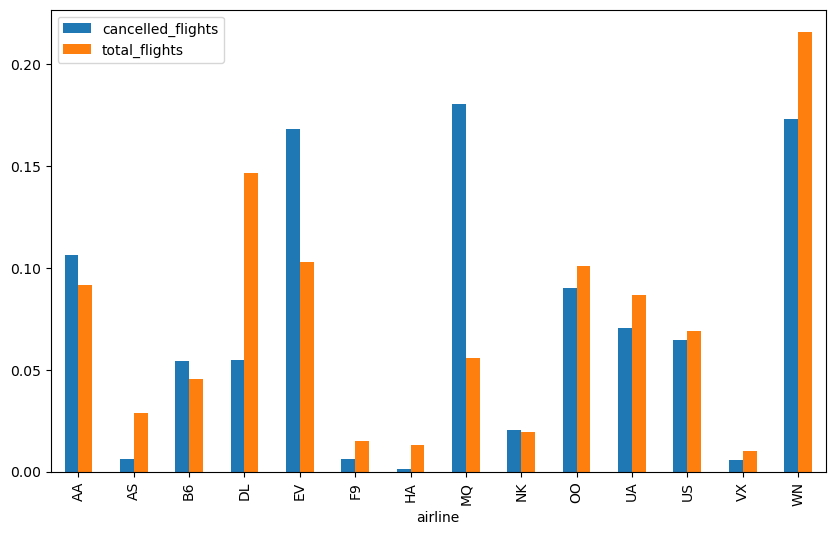

In [102]:
# Contruir Datafrmae g e calcular o nº total de voos cancelados e o nº total de voos para cada airline
g = flights.groupby('airline')['cancelled'].agg(cancelled_flights = 'sum', total_flights = 'size')

g.columns = ['cancelled_flights', 'total_flights']
g['cancelled_flights'] = g['cancelled_flights'] / g['cancelled_flights'].sum()
g['total_flights'] = g['total_flights'] / g['total_flights'].sum()

g.plot.bar()


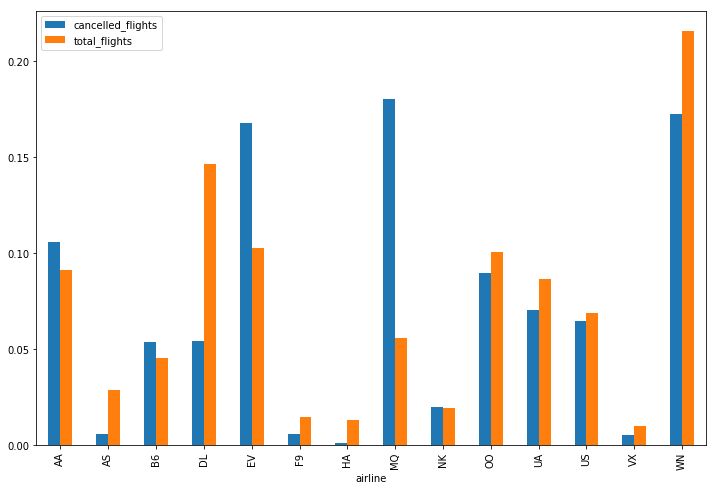

In [103]:
# the bar plot should be similar to this plot

from IPython.display import display, HTML
display(HTML('''
<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAswAAAHrCAYAAADbkMsJAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4wLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvqOYd8AAAIABJREFUeJzt3X2UnWV9L/zvz0AJJYi8VVvwmNDiCwYImmARQUtVQF2gVSrYKhQVq6KUtjxS7bIp2i4ULVWrVaoexUfFCqd90sqpVbEF5aBEDSAvKi8RQykHQRFqefV6/tg7cQjJlT2QyZ4dPp+1ZrH3fd97z3cPk5nvXPu6r7taawEAANbtEeMOAAAAs5nCDAAAHQozAAB0KMwAANChMAMAQIfCDAAAHQozAAB0KMwAANChMAMAQIfCDAAAHVuMO8DadtpppzZ//vxxxwAAYDP3jW9844ettZ03dNysK8zz58/P8uXLxx0DAIDNXFV9f5TjTMkAAIAOhRkAADoUZgAA6Jh1c5jX5Z577smqVaty5513jjsKM2Du3LnZdddds+WWW447CgDAA0xEYV61alW23XbbzJ8/P1U17jhsRK213HLLLVm1alUWLFgw7jgAAA8wEVMy7rzzzuy4447K8maoqrLjjjt69wAAmLUmojAnUZY3Y/7fAgCz2cQUZgAAGIeJmMO8tvknf26jPt/KU5+/UZ9vY/nYxz6W5cuX52/+5m+ydOnSzJs3L3/8x3888uPnzZuXO+64Y737TzrppJx77rl53vOel2222WbN87/1rW/NgQcemGc/+9nrfez68vz4xz/Opz71qbzuda8bOScAwGxmhPlh7Iwzzsill16a00477X7bTznllG5Z7vnxj3+cD3zgAxsjHgDArKAwT8OZZ56ZvfbaK3vvvXde/vKX55/+6Z/ytKc9Lfvss0+e/exn56abbkoyGH099thj86xnPSu77bZb3vve9673OZLk5ptvzotf/OIsWbIkS5YsyVe/+tVujmuuuSaHHHJInvrUp+aAAw7IVVddlSS57rrrst9++2XPPffMn/7pn3af47DDDssdd9yRpz71qfnMZz5zv33HHHNMzj777CTJueeemyc+8Yl56lOfmje+8Y15wQtesOa4K6644gGv8eSTT84111yTRYsW5aSTTsqNN96YAw88MIsWLcrChQtzwQUXjPKlBgCYNSZySsY4XH755Xn729+eCy+8MDvttFNuvfXWVFUuuuiiVFU+/OEP553vfGfe/e53J0muuuqqfPnLX87tt9+eJzzhCXnta1+b7373uw94jiQ54YQTcuKJJ+YZz3hGrr/++hx88MG58sor15vluOOOywc/+MHsvvvu+drXvpbXve51Oe+883LCCSfkta99bV7xilfk/e9/f/f1LFu2LPPmzcuKFSuSDEr+2u6888685jWvyfnnn58FCxbkqKOOut/+db3GU089Nd/+9rfXPO+73/3uHHzwwXnLW96S++67Lz/96U9H/poDAMwGCvOIzjvvvBxxxBHZaaedkiQ77LBDLrvssrz0pS/NjTfemLvvvvt+6wg///nPz1ZbbZWtttoqv/RLv5Sbbrppnc+RJF/84hdzxRVXrHnsT37yk/XOPb7jjjty4YUX5ogjjliz7a677kqSfPWrX80555yTJHn5y1+eN73pTQ/pNV911VXZbbfd1ryuo446KmeccUb3Na5tyZIlOfbYY3PPPffkhS98YRYtWvSQMgEAbGqmZDwEb3jDG3L88cfnsssuy4c+9KH7rSW81VZbrbk9Z86c3Hvvvet9np/97Ge56KKLsmLFiqxYsSI33HBD5s2bt95jH/WoR605dsWKFfcbjd6US7SN8hoPPPDAnH/++dlll11yzDHH5Mwzz9xk+QAANgaFeUQHHXRQPvvZz+aWW25Jktx666257bbbsssuuyRJPv7xjz+o50iS5z73uXnf+9635rjV0xnW5ZGPfGQWLFiQz372s0kGV8q75JJLkiT7779/zjrrrCTJJz/5yem+xAd4whOekGuvvTYrV65MkgfMdV6XbbfdNrfffvua+9///vfz6Ec/Oq9+9avzqle9Kt/85jcfci4AgE1pIqdkjGMZuCc/+cl5y1vekmc+85mZM2dO9tlnnyxdujRHHHFEtt9++xx00EG57rrrpv0cH/vYx/Le9743r3/967PXXnvl3nvvzYEHHpgPfvCD632eT37yk3nta1+bt7/97bnnnnty5JFHZu+998573vOevOxlL8s73vGOHH744Q/5NW+99db5wAc+kEMOOSTbbLNNlixZssHH7Ljjjtl///2zcOHCHHrooVm4cGFOO+20bLnllpk3b54RZgBg4lRrbdwZ7mfx4sVt+fLl99t25ZVX5klPetKYEj283XHHHZk3b15aa3n961+f3XffPSeeeOJG/zz+HwMAm1pVfaO1tnhDx5mSQdff/d3fZdGiRXnyk5+c2267La95zWvGHQkAYJOayCkZjO6yyy5bs97zaltttVW+9rWvjfT4E088cUZGlAEANmjpdtM8/rYZiaEwb+b23HPP7kmEAAD0mZIBAAAdCjMAAHQozAAA0DGZc5inOwF8g883MxPEAQCYfEaYR/TjH/84H/jAB7rHrFy5Mp/61Kc2+FwrV67MwoULu8ccddRR2WuvvXL66afnmGOOydlnn50kedWrXpUrrrii+9ipxz+YfAAA/JzCPKKNWZg35D//8z9z8cUX59JLL33Akm4f/vCHs8ceezyo51WYAQCmT2Ee0cknn5xrrrkmixYtykknnZSTTjopCxcuzJ577pnPfOYza4654IILsmjRopx++ulZuXJlDjjggDzlKU/JU57ylFx44YUjfa7nPve5ueGGG7Jo0aJccMEF99v3rGc9K6uvhPiRj3wkj3/847Pvvvvm1a9+dY4//vg1x51//vl5+tOfnt12223NaPPa+S6//PLsu+++WbRoUfbaa69873vf2xhfKgCAzcpkzmEeg1NPPTXf/va3s2LFipxzzjn54Ac/mEsuuSQ//OEPs2TJkhx44IE59dRT8653vSv//M//nCT56U9/mi984QuZO3duvve97+Woo47K2pf9Xpdly5blBS94wZr1kz/ykY884Jj/+I//yNve9rZ885vfzLbbbpuDDjooe++995r9N954Y77yla/kqquuymGHHZaXvOQlD8j3hje8ISeccEJ+53d+J3fffXfuu+++jfGlAgDYrCjMD8JXvvKVHHXUUZkzZ04e/ehH55nPfGYuvvjiPPKRj7zfcffcc0+OP/74rFixInPmzMl3v/vdjZbh61//ep75zGdmhx12SJIcccQR93v+F77whXnEIx6RPfbYIzfddNM6n2O//fbLX/zFX2TVqlX5rd/6rey+++4bLR8AwObClIwZdPrpp+fRj350Lrnkkixfvjx33333JvvcW2211ZrbrbV1HvOyl70sy5Yty9Zbb53nPe95Oe+88zZVPACAiTGZI8xjWAZu2223ze23354kOeCAA/KhD30oRx99dG699dacf/75Oe2003LDDTesOSZJbrvttuy66655xCMekY9//OMbdcrDkiVL8gd/8Af50Y9+lG233TbnnHNO9txzz5FfQ5Jce+212W233fLGN74x119/fS699NIcdNBBGy0jAMDmYDIL8xjsuOOO2X///bNw4cIceuih2WuvvbL33nunqvLOd74zj3nMY7Ljjjtmzpw52XvvvXPMMcfkda97XV784hfnzDPPzCGHHJJtttlmo+XZZZdd8uY3vzn77rtvdthhhzzxiU/Mdtv116fea6+97pfvrrvuyic+8YlsueWWecxjHpM3v/nNGy0fAMDmotb3dv24LF68uK19YtyVV16ZJz3pSWNKNHvdcccdmTdvXu6999686EUvyrHHHpsXvehF4471oPh/DAA8wHQvVjfNWQhV9Y3W2uINHWcO8wRbunRpFi1alIULF2bBggV54QtfOO5IAACbHVMyxujzn/983vSmN91v24IFC/IP//APIz3+Xe9610zEAgBgiokpzK21VNW4Y2xUBx98cA4++OBxxxi72TYtCABgqomYkjF37tzccsstitVmqLWWW265JXPnzh13FACAdZqIEeZdd901q1atys033zzuKMyAuXPnZtdddx13DACAdZqIwrzllltmwYIF444BAMDD0ERMyQAAgHFRmAEAoENhBgCADoUZAAA6FGYAAOhQmAEAoGOkwlxVh1TVd6rq6qo6eR37/7CqrqiqS6vqS1X1uCn7jq6q7w0/jt6Y4QEAYKZtsDBX1Zwk709yaJI9khxVVXusddi3kixure2V5Owk7xw+dockf5bkaUn2TfJnVbX9xosPAAAza5QR5n2TXN1au7a1dneSs5IcPvWA1tqXW2s/Hd69KMnqy7YdnOQLrbVbW2s/SvKFJIdsnOgAADDzRinMuyT5wZT7q4bb1ueVSf73dB5bVcdV1fKqWu7y1wAAzCYb9aS/qvrdJIuTnDadx7XWzmitLW6tLd555503ZiQAAHhIRinMNyR57JT7uw633U9VPTvJW5Ic1lq7azqPBQCA2WqUwnxxkt2rakFV/UKSI5Msm3pAVe2T5EMZlOX/O2XX55M8t6q2H57s99zhNgAAmAhbbOiA1tq9VXV8BkV3TpKPttYur6pTkixvrS3LYArGvCSfraokub61dlhr7daqelsGpTtJTmmt3TojrwQAAGbABgtzkrTWzk1y7lrb3jrl9rM7j/1oko8+2IAAADBOrvQHAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAxxbjDgDApjf/5M9N6/iVpz5/hpIAzH5GmAEAoENhBgCADoUZAAA6FGYAAOhQmAEAoENhBgCADoUZAAA6FGYAAOhQmAEAoENhBgCADoUZAAA6FGYAAOhQmAEAoENhBgCAji3GHQAAgIeH+Sd/blrHr5w7Q0GmyQgzAAB0KMwAANChMAMAQIfCDAAAHQozAAB0KMwAANChMAMAQIfCDAAAHS5cAhNs2gvAn/r8GUoCAJsvI8wAANChMAMAQIfCDAAAHQozAAB0KMwAANChMAMAQIfCDAAAHQozAAB0KMwAANChMAMAQIfCDAAAHQozAAB0KMwAANChMAMAQIfCDAAAHQozAAB0KMwAANChMAMAQIfCDAAAHQozAAB0KMwAANChMAMAQIfCDAAAHQozAAB0KMwAANChMAMAQIfCDAAAHQozAAB0KMwAANChMAMAQMdIhbmqDqmq71TV1VV18jr2H1hV36yqe6vqJWvtu6+qVgw/lm2s4AAAsClssaEDqmpOkvcneU6SVUkurqplrbUrphx2fZJjkvzxOp7iv1trizZCVgAA2OQ2WJiT7Jvk6tbatUlSVWclOTzJmsLcWls53PezGcgIAABjM8qUjF2S/GDK/VXDbaOaW1XLq+qiqnrhug6oquOGxyy/+eabp/HUAAAwszbFSX+Pa60tTvKyJH9dVb+69gGttTNaa4tba4t33nnnTRAJAABGM0phviHJY6fc33W4bSSttRuG/702yb8l2Wca+QAAYKxGKcwXJ9m9qhZU1S8kOTLJSKtdVNX2VbXV8PZOSfbPlLnPAAAw222wMLfW7k1yfJLPJ7kyyd+31i6vqlOq6rAkqaolVbUqyRFJPlRVlw8f/qQky6vqkiRfTnLqWqtrAADArDbKKhlprZ2b5Ny1tr11yu2LM5iqsfbjLkyy50PMCAAAY+NKfwAA0DHSCDMwtHS7aR5/28zkAAA2GSPMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQscW4AzxU80/+3LSOX3nq82coCQAAmyMjzAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0DHxq2QA07B0u2kef9vM5ACACWKEGQAAOkYqzFV1SFV9p6qurqqT17H/wKr6ZlXdW1UvWWvf0VX1veHH0RsrOAAAbAobLMxVNSfJ+5McmmSPJEdV1R5rHXZ9kmOSfGqtx+6Q5M+SPC3Jvkn+rKq2f+ixAQBg0xhlDvO+Sa5urV2bJFV1VpLDk1yx+oDW2srhvp+t9diDk3yhtXbrcP8XkhyS5NMPOTkAPFw4/wDGapQpGbsk+cGU+6uG20Yx0mOr6riqWl5Vy2+++eYRnxoAAGberDjpr7V2RmttcWtt8c477zzuOAAAsMYohfmGJI+dcn/X4bZRPJTHAgDA2I1SmC9OsntVLaiqX0hyZJJlIz7/55M8t6q2H57s99zhNgAAmAgbLMyttXuTHJ9B0b0yyd+31i6vqlOq6rAkqaolVbUqyRFJPlRVlw8fe2uSt2VQui9OcsrqEwABAGASjHSlv9bauUnOXWvbW6fcvjiD6RbreuxHk3z0IWQEAICxmRUn/QEAwGylMAMAQIfCDAAAHQozAAB0KMwAANChMAMAQIfCDAAAHQozAAB0KMwAANChMAMAQIfCDAAAHVuMO8Amt3S7aR5/28zkAABgIhhhBgCADoUZAAA6Hn5TMgBgzOaf/LlpHb9y7gwFAUZihBkAADoUZgAA6FCYAQCgQ2EGAIAOhRkAADqskgEAzCwXDWPCGWEGAIAOhRkAADoUZgAA6FCYAQCgQ2EGAIAOhRkAADoUZgAA6FCYAQCgQ2EGAIAOhRkAADoUZgAA6FCYAQCgQ2EGAIAOhRkAADoUZgAA6FCYAQCgQ2EGAIAOhRkAADoUZgAA6FCYAQCgQ2EGAIAOhRkAADoUZgAA6FCYAQCgQ2EGAIAOhRkAADoUZgAA6FCYAQCgQ2EGAIAOhRkAADq2GHcAAGCyzD/5c9M6fuXcGQoCm4gRZgAA6FCYAQCgw5QMAID1WbrdNI+/bWZyMFZGmAEAoENhBgCADoUZAAA6FGYAAOhQmAEAoENhBgCADoUZAAA6rMMMADysTOfS3i7rTWKEGQAAuhRmAADoUJgBAKBDYQYAgA6FGQAAOhRmAADoUJgBAKBDYQYAgA6FGQAAOhRmAADoUJgBAKBDYQYAgA6FGQAAOhRmAADoUJgBAKBDYQYAgI4txh0AgAmwdLtpHn/bzOQAGAMjzAAA0KEwAwBAhykZPKzNP/lz0zp+5dwZCgIAzFoKMw/JtAvnqc+foSQAADPDlAwAAOhQmAEAoENhBgCAjpEKc1UdUlXfqaqrq+rkdezfqqo+M9z/taqaP9w+v6r+u6pWDD8+uHHjAwDAzNrgSX9VNSfJ+5M8J8mqJBdX1bLW2hVTDntlkh+11n6tqo5M8o4kLx3uu6a1tmgj5wYAgE1ilBHmfZNc3Vq7trV2d5Kzkhy+1jGHJ/n48PbZSX6zqmrjxQQAgPEYpTDvkuQHU+6vGm5b5zGttXuT3JZkx+G+BVX1rar696o6YF2foKqOq6rlVbX85ptvntYLAACAmTTTJ/3dmOR/tNb2SfKHST5VVY9c+6DW2hmttcWttcU777zzDEcCAIDRjVKYb0jy2Cn3dx1uW+cxVbVFku2S3NJau6u1dkuStNa+keSaJI9/qKEBAGBTGaUwX5xk96paUFW/kOTIJMvWOmZZkqOHt1+S5LzWWquqnYcnDaaqdkuye5JrN050AACYeRtcJaO1dm9VHZ/k80nmJPloa+3yqjolyfLW2rIkH0nyiaq6OsmtGZTqJDkwySlVdU+SnyX5/dbarTPxQgAAYCZssDAnSWvt3CTnrrXtrVNu35nkiHU87pwk5zzEjAAAMDau9AcAAB0KMwAAdCjMAADQMdIcZtholm43zeNvm5kcAAAjMsIMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0LHFuAMwTUu3m+bxt81MDgCAhwkjzAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHRsMe4AADBd80/+3LSOX3nq82coCfBwoDADsPlbut00j79tZnIAE8mUDAAA6FCYAQCgQ2EGAIAOhRkAADoUZgAA6FCYAQCgQ2EGAIAOhRkAADpcuASYHNO5+IQLTwCwkRhhBgCADoUZAAA6TMkA2BSmM50kMaUEYBYxwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB1WyQAA2FxZoWejMMIMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0GEd5jGbf/LnpnX8yrkzFATGwPc/AJNAYQYAmBAGGsbDlAwAAOhQmAEAoENhBgCADoUZAAA6FGYAAOhQmAEAoGOkwlxVh1TVd6rq6qo6eR37t6qqzwz3f62q5k/Z9yfD7d+pqoM3XnQAAJh5G1yHuarmJHl/kuckWZXk4qpa1lq7Ysphr0zyo9bar1XVkUnekeSlVbVHkiOTPDnJryT5YlU9vrV238Z+IQCbkrVQAR4+Rhlh3jfJ1a21a1trdyc5K8nhax1zeJKPD2+fneQ3q6qG289qrd3VWrsuydXD5wMAgIlQrbX+AVUvSXJIa+1Vw/svT/K01trxU4759vCYVcP71yR5WpKlSS5qrf2/w+0fSfK/W2tnr/U5jkty3PDuE5J856G/tPXaKckPZ/D5Z5r84yX/eE1y/knOnsg/bvKPzyRnT+TfkMe11nbe0EGz4tLYrbUzkpyxKT5XVS1vrS3eFJ9rJsg/XvKP1yTnn+TsifzjJv/4THL2RP6NZZQpGTckeeyU+7sOt63zmKraIsl2SW4Z8bEAADBrjVKYL06ye1UtqKpfyOAkvmVrHbMsydHD2y9Jcl4bzPVYluTI4SoaC5LsnuTrGyc6AADMvA1OyWit3VtVxyf5fJI5ST7aWru8qk5Jsry1tizJR5J8oqquTnJrBqU6w+P+PskVSe5N8vpZsELGJpn6MYPkHy/5x2uS809y9kT+cZN/fCY5eyL/RrHBk/4AAODhzJX+AACgQ2EGAIAOhRkAADoedoW5qh5bVSeNOweTraqeNu4MTKaqevS4MzycDVd7YkyqastxZ5iuqtp+ePXiWa2q5nX2/eqmzLI5elgU5qrauapeV1UXJPm3JLP+F1ZVPa6qtpty/zeq6j1V9YeT8gO/qv5HVc0d3q6q+r2qel9VvXa4Xvck++y4A2xIVV1RVX866T8oq2pxVb2oqg6rqieOO8+DUVWPqqpXVtWXknxr3HlGUVX7VNUnq+qbw48zqmr34b5Z/e+3qt66nu3bJfnXTRxn2qrq0Ko6v6p+OPz496p63rhzPVjDn/+/Obza76px5+mpqreu/jkzXBL3y0muSXJTVT17vOk26JKq+u2pG6pqblW9PYOVzma1qnpF72Pc+TbbwlxV21bV0VX1+QzWfv7VJAtaa7/aWvvjMccbxd8n2SZJqmpRBgXt+iR7J/nAGHNNx7n5+ffYqUmen+RrSZZkliwT8xDM+tGGJEdl8D30r1X19ao6sap+ZdyhRlVVz6yq5Rl873w0yXFJPlJV/1ZVj+0/evyqauuqOrKqliW5LMm7k7wtgws4zWpV9eIMfuZ8Kckxw4+Lkny2qvbL7P/l+4yq+oupG4Yj+/+e5LzxRBpNVb06g++TpUl2G378eZKlVXXcGKNNW1X9elW9N8n3k/x/Sc5PMtv/6H1pku8Mb6++vsTOSZ6Z5C/Hkmh0z03ye1X1r1X1a1V1eAY/e7ZKsmi80UayZD0fb8vgd8B4tdY2y48k/53BD8cD8vPl864dd65p5L90yu13JXnn8PYjpu6bzR9Jrphy+xtJHjHl/iXjzvcQX9v1484wzby/nuT0DP7o+nKSV4870wiZv5Vk5+HtBUn+YXj7OUn+ddz5NpD9U0l+kMEa9c/JYA3768adaxr5L00yfx3b5ye5M8lfjjvjBvLPTfLPSf5qeH/3JFcn+f1xZxsh+xVJdljH9h2TXDnufCO+hr9M8r0M/uB61TD7dePONWL2b025fU6S10y5/81x5xvxNZyUwbUvViV58rjzPMjXUEl+N4PC/5kke40702Y7wpzkTzL4q+oDSf5kAt+WnjqCeVAGP3jSWvtZJmN0M0l+UFUHDW+vzM8vn77j2BJNQ1X9U1UtW8fHP2XwC2BitNYuaq2dmOQVSR6V5G/GHGkUc1prNw9vX5/kcUnSWvtCkl3Glmo0eyT5UZIrMyg59yWZpEXvt2itrVx743Db91trb97kiaahtXZnkhclmV9Vn07yxSQntdY+ON5kI6nW2q1rb2yt3TKOMA/Sq5LclORvk3ximH3KhY20AAAJp0lEQVRSvv/vqqqFVbVzkt/I/afw/OKYMo2kqraoqj9J8vtJXpdkeZL3VtUTxptsdMPX8KoMfnY+O8lLWmsvba1dOuZoG77S36Rqrf11kr+uqt0yuPLgPyb5lap6UwYjVd8da8ANO294lcQbk2yf4duIVfXLGYzwTIJXJTmzqpYmuS3JiqpakUFh+8NxBhvRux7kvlmlqpZkMD3jxUmuS/KhTMAc7CTLh3Mez0tyWAbnH6SqfjGDEdtZq7W2aDgP8qgkX6yqHybZtqoe3Vq7aczxRnFPVf2P1tr1UzdW1eOS3DWmTCOrqtU/X76W5P9JckGSBau3t9b+alzZRvCTqtq7tXbJ1I1VtXeS28eUabp+OYN3Vo7K4Pfwl5NsXVVbtNbuHW+0DTohydkZTMP4q9badUkynEM+288/+FYG76w/pbV2W5IzquoFSZZV1Tmz/Q/dqnp9Bl//LyU5ZF1/tI/Tw+pKf1W1MMl7MnircVaPOFdVZTCX6peT/H1r7Ybh9gOSfGy255+qqp6U5PEZ/IG2KsnFw5HyiTEcbciUEc9Zr6r+MoPvoVuTnJXkM621WX3CzVQ1OJv+1RmM1l6S5KOttfuqauskv9Ra+/5YA05DVT01ycuSHJFkVWvt6WOO1FVVL0zyzgzeWv/GcPPiJCcneVNr7R/HlW0UVfVnvf2ttT/fVFmmq6qekeSTSf5n7v+1PzrJ77bWvjKubA9GVW2V5AUZlOcDknyptfay8aZav+EfVavfxW3Djx8m+crq8jxbVdW5GUyX+spa27dO8qettbeMJ9loqupnSf5vkptz/3ckKklrre01lmCrQzwcCnNV7ZPBP9bfzmBqwDmttfeNNdQ0DPOv/mV7XZL/NUn5p6qqnZLc0ibkG2/4i/cNGcwdrwzmhb2vtXbKWIONYLhSwKdba98bd5YHY10jnJNu+IfwAa2188edZUOGI5p/lOTJw01XJHnX2iOfbHzDExT/KIMT/pLB7613tdb+c2yhpmHKCP9qq0vnJUkWtdbO3PSpRrOeP7Z2SHJwkqWttbM2caSRVdUJGbyj/ssZLBzw6dbabB8VX6OqTkzy1QwGee5Ze/+4B0k22ykZVfX4DEryURn8Q/1MBn8gPGucuUbVyf8bYw02DVX16xmscHBrBme5fiLJTkkeUVWvaK39yzjzbcjwh/4zkiyZ8rbcbkn+tqpObK2dPtaAG3bn6rJcVUe01tZMw6iqv5ztb89lMI3qKUkyfDvxxWPOM7Kqel/6czZnfWEeFuOxL+X0YNR6lpUbaq21t22yMNNUgyX7/ijJsRnM3U+SZyX5WVW9pbX2gCIxC227jm3zk7wlgxU/Zq31vftQVTtkMBd+1hbm1tp7krxnOHXqyCQfHY4ufzrJpyZg8GSXJH+dwUoql2VQni9McuG65vVvapvtCPNwaP+CJK9srV093HZta223/iNnh0nPnyTDJcHenGS7DJaRO7S1dtFwbuenW2v7jDXgBlTVt5I8p7X2w7W275zBKg2zPf83W2tPWfv2uu7PRlX1rdVf46m3J0FVHT3l7p8nud+oVWvt45s20fQMl8Jbr9baYZsqy4NRVX+0js3bJHllkh1ba+u9wMO4VdXpGRTOE1trtw+3PTKD8yb+u7V2wjjzPRSrS+ds/9mzPpP2cyhZ8w71RzNYZWJWn/uxWg2uNbE4ydOT7Df8+HFrbY9x5tpsR5iT/FYGf2F9uar+JYO/CidldYlk8vMngzPt/zVJquqU1tpFSdJau6pm/0WTkmTLtctyMpjHXJNxtapaz+113Z+N2npuz3pTC3FV/cFsL8jrsF8Gy+J9OoMT5ybh+2WN1tq7V9+uqm0zOJHo9zL4Ofru9T1ulnhBksdPnbbWWvtJVb02yVUZvJaJ1Fq7tSbkh//aquo3Mlj5ZtYbvktxaAYd4jczOGF66RgjTdfWSR6ZwWDbdkn+I4MR57HabAvz8KSUf6yqbZIcnuQPkvxSVf1tBqtkzOqrPU16/qGpJ/b991r7JqEA3f0g980WvcI5CV//vavqJxmUta2Ht5OfnwDyyPFFm5ZJ+Fqv7TH5+SoHL0vyuQzeFbp8rKmmYTia+YdJfifJxzNYOWASCk9b1zkewxNeJ/F7aY1JKJ1VdVke+G92hwxK26yeolRVq//NPi+DC7adleS41tp/jTXYiKrqjAzOmbg9gz/UL8xgpZJZ8T2z2U7JWJeq2j6DE+de2lr7zXHnma5Jy19V9yX5rwwLT5Kfrt6VZG5rbVaP0k7J/4Bdmaz8E/n131xMwvSXnuEqB0clOS3Jn7fWZv0a3lV1Wgbv0p2R5P2ttTvGHGlkVfWPGZzYfeZa2383yW/P9ukwyYZLZ2vtqk2fajTD+b9TtQxOVJ/1pbOqzsvgoknnzJaSOR3Dd9N3SvLtDMry/0ny7dmySMDDqjADbApVdXt+Xhh+Mff/Y2UiRseHRfn5GZTl+UmWZbC03w3jzDWK4Tkgd2Wwqs26lqeatV//qtolyf/K4F25qcvKbZ3kRRPy9Z/Y0sl4DafsPDmD+ctPT7Iwg4UD/k9rrbtc5IxnU5gBmKqqzszgF9W5Sc5qrX17zJEedmpwldQ1S/q11r40zjywKVXVrkn2z6A0vyCDk3UfNdZMCjMAUw1HaFePBk7UCC0wmarqjfn5yPI9GS4pN/y4bNwXPNtsT/oD4MFprT1i3BmAh535ST6bwZKKN445ywMYYQYAgA6jCAAA0KEwAwBAh8IMMMtV1blVtc4zxKtqZVXtNLx94aZNBvDwYA4zwAQarldaSa5Nsnhdl3EHYOMwwgwwi1TVP1bVN6rq8qo6brhtZVXtVFXzq+o7w3WSv53ksWs99o7hf59VVf9WVWdX1VVV9clhwU5VPbWq/n34OT5fVb+8qV8jwKSxrBzA7HJsa+3Wqto6ycVVdc5a+3dPcnRr7aIkGfbgddkngwtf/EeSrybZv6q+luR9SQ5vrd1cVS9N8hdJjp2B1wGw2VCYAWaXN1bVi4a3H5tBQZ7q+6vL8gZ8vbW2KkmqakUGa5z+OIMr+H1hWLTnJJl1650CzDYKM8AsUVXPSvLsJPu11n5aVf+WZO5ah/3X2o9bj7um3L4vg5/3leTy1tp+DzEqwMOKOcwAs8d2SX40LMtPTPLrG/n5v5Nk56raL0mqasuqevJG/hwAmx2FGWD2+JckW1TVlUlOTTLK1IuRtdbuTvKSJO+oqkuSrEjy9I35OQA2R5aVAwCADiPMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdPz/LkogeK7KGxgAAAAASUVORK5CYII=&#10">
'''))

Com este gráfico verificamos que as companhias aéreas EV e MQ têm, percentualemnte, muito mais voos cancelados do que voos concluídos. Normalmente este tipo de informação é útil para melhorar a performance dos modelos (através de técnicas como one-hot encoding).

Estamos agora em condições de analisar a distribuição dos motivos de atraso (colunas `airline_delay`, `late_aircraft_delay`, `air_system_delay`, `security_delay` e `weather_delay`) por mês - <b>apenas para os voos com atraso</b>. 
<br>
<div class="alert alert-success">
Q.6<br>
    Portanto, a ideia é, para cada mês, obter a percentagem dos atrasos que cada motivo de atraso representa. Assim, construa o dataframe <code>delays</code> com esta informação mensal.
    <br><br>
    A variável <code>total_delay</code> tem, para cada mês, a soma de todos os atrasos. 
</div>

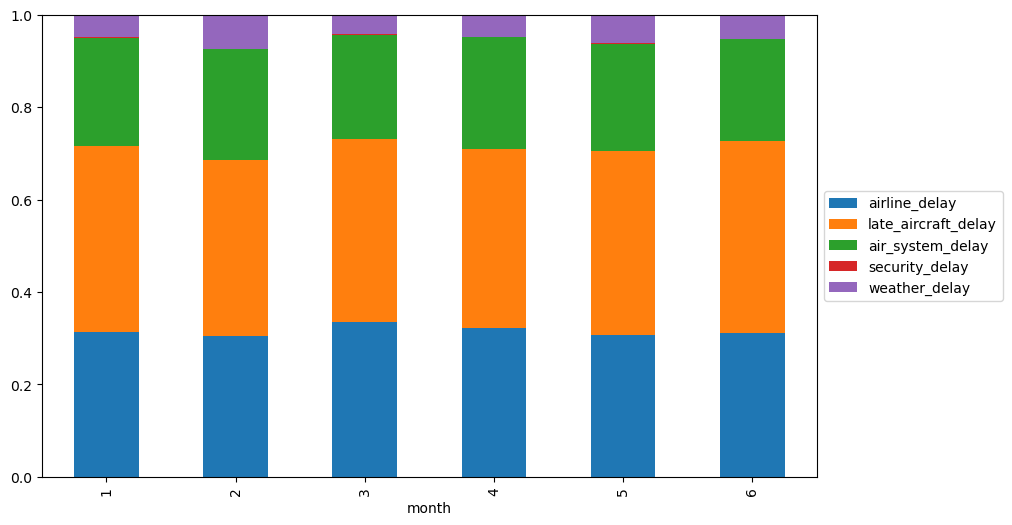

In [104]:
# delays dataframe should have this format
#
#        airline_delay  late_aircraft_delay  air_system_delay  security_delay   weather_delay  
# month                                                                                         
# 1      1,708,155.000        2,183,865.000     1,278,055.000       6,700.000     263,087.000   
# 2      1,712,660.000        2,157,918.000     1,349,173.000       4,580.000     411,265.000   
# 3      1,818,680.000        2,156,090.000     1,228,893.000       6,586.000     228,661.000   
# 4      1,490,594.000        1,785,437.000     1,118,027.000       3,660.000     221,590.000   
# 5      1,667,920.000        2,172,521.000     1,254,652.000       5,711.000     336,555.000   
# 6      2,296,333.000        3,055,836.000     1,630,868.000       7,084.000     380,699.000   

columns = 'month airline_delay late_aircraft_delay air_system_delay security_delay weather_delay'.split()

# Construção do DataFrame "delays": agrupar e somar os atrasos para cada motivo de atraso por mês
delays = flights[columns].groupby('month').sum()

total_delay = delays.sum(axis = 1)

delays_prc = delays.copy()
for c in delays.columns: 
    delays_prc[c] = delays_prc[c] / total_delay
    
delays_prc.plot.bar(stacked=True, ylim=(0,1)).legend(loc='center left', bbox_to_anchor=(1, 0.5))


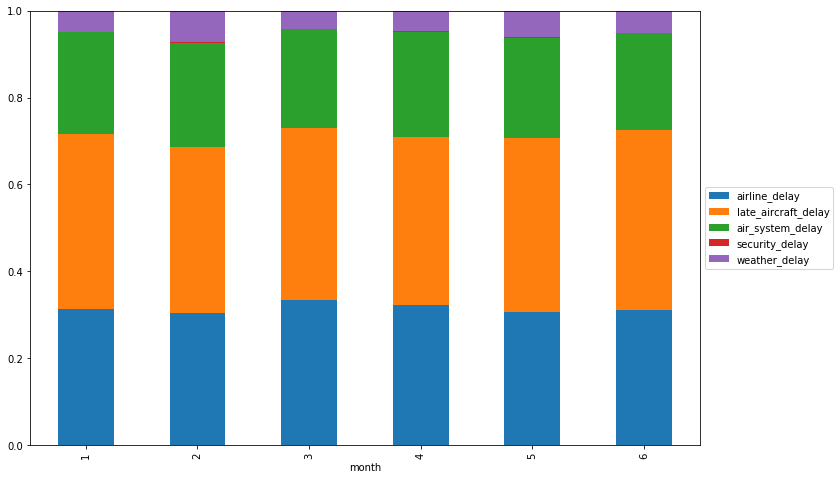

In [105]:
# the bar plot should be similar to this plot

from IPython.display import display, HTML
display(HTML('''
<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA0gAAAHgCAYAAACfN01xAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4wLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvqOYd8AAAIABJREFUeJzt3XtcV1W+//H3B1AUJbyAdw0VuXxBmYIoyxlNbcoy05ymzElLzbJxus9jOk3jr9Pc8jR1ysd0USsrrXFmcibNmunoqczpNmKKCkJqopaa4gXxhgLr94cLDxEIKfAVfT0fDx99995r7/2B9Uh8s9Ze25xzAgAAAABIIcEuAAAAAABOFwQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAr8aAZGYvmtkOM1tTzXEzs2lmtt7MVpnZ+XVfJgAAAADUv9qMIL0k6YoTHB8iqZf/M1HSs6deFgAAAAA0vBoDknPuA0m7T9DkGkmvuGM+kdTKzDrWVYEAAAAA0FDq4hmkzpK2VNj+0u8DAAAAgEYlrCFvZmYTdWwanlq0aJGWmJjYYPfesamowe4VDO3OjQx2CfXqTO4/+q5xo/8atzO5/+i7xo3+q1vLly8vcM7FNOhN0WjVRUD6SlLXCttd/L5vcc7NkDRDktLT011mZmYd3L52nr793Qa7VzD89LmBwS6hXp3J/UffNW70X+N2Jvcffde40X91y8w2NegN0ajVxRS7BZLG+NXsLpJU6JzbVgfXBQAAAIAGVeMIkpn9SdIASdFm9qWk/yepiSQ5556T9LakKyWtl3RQ0i31VSwAAAAA1KcaA5JzblQNx52kn9ZZRQAAAAAQJHUxxQ4AAAAAzggEJAAAAADwCEgAAAAA4BGQAAAAAMAjIAEAAACAR0ACAAAAAI+ABAAAAAAeAQkAAAAAPAISAAAAAHgEJAAAAADwCEgAAAAA4BGQAAAAAMAjIAEAAACAFxbsAgCc2Z7re1ewS6hXP9XqYJcAAADqECNIAAAAAOAxggQAqNbA938a7BLq2dpgFwAAOM2cNQGJaT4A8N39+D/O7B8T/M0JAKjszP7JBwAA0Ajxi10geHgGCQAAAAA8AhIAAAAAeAQkAAAAAPB4BgkAgDMQKxACwMkhIAEAcAZiBUIAODlMsQMAAAAAj4AEAAAAAB4BCQAAAAC8M3uCMs4YZ/bDxjxoDAAAcLogIKFROJMfNuZBYwAAgNMHU+wAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBXq4BkZleYWZ6ZrTezB6o43s3M3jOzFWa2ysyurPtSAQAAAKB+1RiQzCxU0tOShkgKSBplZoFKzR6S9Bfn3HmSbpD0TF0XCgAAAAD1rTYjSBmS1jvnvnDOHZE0V9I1ldo4Sef4z1GSttZdiQAAAADQMMJq0aazpC0Vtr+UdGGlNg9L+h8z+5mkFpIG10l1AAAAANCA6mqRhlGSXnLOdZF0paTZZvata5vZRDPLNLPMnTt31tGtAQAAAKBu1CYgfSWpa4XtLn5fReMl/UWSnHMfS2omKbryhZxzM5xz6c659JiYmJOrGAAAAADqSW0C0jJJvcysu5k11bFFGBZUarNZ0iBJMrMkHQtIDBEBAAAAaFRqDEjOuRJJkyW9I2mtjq1Wl21mj5jZMN/sPkm3mlmWpD9Jutk55+qraAAAAACoD7VZpEHOubclvV1p35QKn3MkXVK3pQEAAABAw6qrRRoAAAAAoNEjIAEAAACAR0ACAAAAAI+ABAAAAAAeAQkAAAAAPAISAAAAAHgEJAAAAADwCEgAAAAA4BGQAAAAAMAjIAEAAACAR0ACAAAAAI+ABAAAAAAeAQkAAAAAPAISAAAAAHgEJAAAAADwCEgAAAAA4BGQAAAAAMAjIAEAAACAR0ACAAAAAI+ABAAAAAAeAQkAAAAAPAISAAAAAHgEJAAAAADwCEgAAAAA4BGQAAAAAMALC3YBAM5sqzduDnYJAAAAtcYIEgAAAAB4jCABAACcZhh9B4KHESQAAAAA8AhIAAAAAOARkAAAAADAO2ueQWIuLwAAAICaMIIEAAAAAB4BCQAAAAC8s2aKHQDgu2N6MgDgbENAAgDgDES4BYCTwxQ7AAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeLwoFo0CLzwEAABAQ2AECQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAC8WgUkM7vCzPLMbL2ZPVBNmx+bWY6ZZZvZa3VbJgAAAADUv7CaGphZqKSnJV0m6UtJy8xsgXMup0KbXpL+Q9Ilzrk9ZtauvgoGAAAAgPpSmxGkDEnrnXNfOOeOSJor6ZpKbW6V9LRzbo8kOed21G2ZAAAAAFD/ahOQOkvaUmH7S7+vonhJ8Wb2oZl9YmZXVHUhM5toZplmlrlz586TqxgAAAAA6kldLdIQJqmXpAGSRkmaaWatKjdyzs1wzqU759JjYmLq6NYAAAAAUDdqE5C+ktS1wnYXv6+iLyUtcM4ddc5tlPS5jgUmAAAAAGg0alykQdIySb3MrLuOBaMbJN1Yqc0bOjZyNMvMonVsyt0XdVkoAAAAUFeWL1/eLiws7HlJKeLVN2eTMklrSkpKJqSlpVW5bkKNAck5V2JmkyW9IylU0ovOuWwze0RSpnNugT/2QzPLkVQq6efOuV119mUAAAAAdSgsLOz5Dh06JMXExOwJCQlxwa4HDaOsrMx27twZ2L59+/OShlXVpjYjSHLOvS3p7Ur7plT47CTd6/8AAAAAp7sUwtHZJyQkxMXExBRu3749pdo2DVkQAAAAcJoIIRydnXy/V5uDCEgAAAAA4NVqih0AAABwJot94K20urxe/qNXLT+Z8/r37x83b968jdHR0aWVj3Xu3Ll3Zmbm2o4dO5acd955iStWrMg99Uq/LS8vr+nQoUN7rVu3LvtU2jRWBCQAAADgNLFkyZL1lfeVlZXp2CP//6e+whGYYgcAAAAExeDBg3smJycnxcXFJf/hD3+Ilo6NEm3bti0sLy+vaWxsbMqIESNi4+Pjkzds2NC04rkRERHnSdLChQsjMzIyEq644ooe3bt3Tx42bFj3srIySdLSpUsjLrjggoTk5OSkfv369dq0aVOT6mpZunRpREJCQiAhISHwxBNPtCvfX1JSottuu61LSkpKUnx8fOCxxx6LrnxuXl5e07S0tIRAIJAUCASSFi1a1EKSRowYETt79uxW5e2GDRvWfc6cOa0qn3+6ISABAAAAQfDqq6/mZ2dnr125cmXO9OnT22/fvj204vHNmzeHT548eef69euz4+Pjj1R3nbVr1zZ/+umnt6xfvz578+bN4YsWLWpZXFxsd955Z7f58+dvyM7OXjt27NiC+++/v3N11xg/fnzsk08+uTkvLy+n4v4nn3wyOioqqnTNmjVrs7Ky1r788ssxubm53whrnTp1Klm6dOnnOTk5a//85z9/cc8993STpAkTJhS8/PLLbSVp165docuXL295/fXX7z2Z71VDYoodAAAAEARTp05t/9Zbb7WSpO3btzfJzs5uVvF4x44djwwaNOhATdfp3bv3gZ49ex6VpOTk5IMbNmxo2qZNm5J169Y1HzhwYLx0bJpeTEzM0arOLygoCC0qKgodMmTIfkkaN27crnfffTdKkhYvXnxObm5uxIIFC1pLUlFRUWhOTk6z5OTkw+XnHzlyxMaPH39uTk5O85CQEG3atClckq666qr9d91117lbt24NmzNnTuurrrpqT5Mm1Q5inTYISAAAAEADW7hwYeSSJUsiMzMzcyMjI8syMjISDh069I3ZXREREWW1uVZ4ePjxB5RCQ0NVUlJizjmLi4s7tHLlylN6Vsk5Z48//vjmkSNH7qu4Py8v7/go0m9/+9v27dq1Ozpv3ryNZWVlat68+fEFL66//vpdM2fObDNv3rw2s2bNyj+VWhoKU+wAAACABrZ3797QqKio0sjIyLIVK1Y0y8rKalGX1+/Tp8/h3bt3hy1evLiFJBUXF1tmZmazqtpGR0eXRkZGlr7zzjstJemll15qU37ssssuK3z22WdjiouLTZJWrVoVvm/fvm9kiMLCwtCOHTseDQ0N1TPPPNO2tPT/FuC7/fbbC6ZPn95ektLS0g6rEWAECQAAAGe9k12W+2SNHDmycMaMGTE9evRI7tGjx+HU1NQap9J9F82aNXNz587dcOedd3YrKioKLS0ttUmTJn2dnp5eZUh54YUX8idMmBBrZhowYMDx0aJ77rmnID8/P7x3795Jzjlr06bN0bfffntDxXPvvvvuHSNHjuw5d+7ctgMHDixs3rz58ZGvrl27lvTs2fPw1Vdffdo/e1TOKi8Z2FDS09NdZmZmw93w4aiGu1cwPFwY7Arq15ncf/Rd40b/NW5ncv/Rd40b/VenzGy5cy694r6srKz81NTUggYt5CxUVFQUEggEAitXrlzbtm3bb73bKViysrKiU1NTY6s6xhQ7AAAAAHXujTfeiExISEi+9dZbd5xO4agmTLEDAAAAzhI33XRTt2XLlrWsuG/SpElf33XXXbvq+l7Dhw8vGj58+Oq6vm59IyABAAAAZ4nZs2dvDnYNpzum2AEAAACAR0ACAAAAAI+ABAAAAAAeAQkAAAAAPBZpAAAAAB6OSqvb6xXW+OLZiIiI8w4ePLiiuuMFBQWhzz//fJsHHnhgZ12W1r9//7h58+ZtjI6OrvOlt2+77bYu//u//xs1aNCgwn79+u0PBAKH09LSqnw5bWV5eXlNhw4d2mvdunXZp9LmVDGCBAAAAJyGdu3aFfrCCy+0q+vrLlmyZH3lcFRWVqbS0prz0tGjR094/LXXXovOzc3Nnj59+pdvvPFGq1WrVjU/tWobHgEJAAAACKLCwsKQvn37xgcCgaT4+PjAnDlzWknSfffd12XLli3hiYmJgdtuu62LJP3qV79qn5KSkhQfHx+45557Op3ouoMHD+6ZnJycFBcXl/yHP/whunx/586de2/bti0sLy+vaWxsbMqIESNi4+Pjkzds2ND09ddfPycQCCQlJCQE+vbtGy9J9957b6fhw4d3P//88xOvvfba7nl5eU3T0tISAoFAUiAQSFq0aFELSRo4cGDcwYMHQ1NSUgL33Xdfx8WLF7d66KGHuiQmJgays7PDq6px6dKlEQkJCYGEhITAE088cTwMlpSU6LbbbutS/rU+9thj0ZXPra6OESNGxM6ePbtVebthw4Z1L/+e1gZT7AAAAIAgioiIKHvrrbfWt2nTpmzbtm1hF154YeKNN9649/HHH/9y6NChzXNzc3Mk6W9/+9s569evb7Zq1aq1zjkNHjw47h//+EfLIUOG7K/quq+++mp++/btS/fv32/nnXde4Cc/+cmeDh06fGOYaPPmzeEvvPDCxkGDBuVv3bo1bPLkybHvv/9+bmJi4pGvv/46tLzdunXrmn366ae5LVu2dEVFRSFLly79PCIiwq1evTp81KhRPdasWbP23XffXR8REXFeeb35+fnhQ4cOLbzlllv2VPe1jx8/Pvapp57aPGTIkP3lIVCSnnzyyeioqKjSNWvWrD106JBdcMEFiVdfffU+Mzt+bqdOnUqqqmPChAkF//3f/93+pptu2rtr167Q5cuXt5w3b97G2vYHAQkAAAAIorKyMrv77ru7fPLJJy1DQkK0Y8eOpl9++eW3/p3+z3/+85wPPvjgnEAgEJCkgwcPhuTm5jarLiBNnTq1/VtvvdVKkrZv394kOzu7WYcOHQ5UbNOxY8cjgwYNOiBJ77//fouMjIyixMTEI5LUvn3742Hqiiuu2NuyZUsnSUeOHLHx48efm5OT0zwkJESbNm2qcnSoJgUFBaFFRUWh5fWPGzdu17vvvhslSYsXLz4nNzc3YsGCBa0lqaioKDQnJ6dZcnLy8eeZqqvjqquu2n/XXXedu3Xr1rA5c+a0vuqqq/Y0adKk1nURkAAAAIAgmj59eptdu3aFrV69em14eLjr3Llz70OHDn3rURjnnO6+++5tP//5zwtquubChQsjlyxZEpmZmZkbGRlZlpGRkVDVNSMiIspqU2OLFi2Ot/vtb3/bvl27dkfnzZu3saysTM2bN6/bBS4kOefs8ccf3zxy5Mh9Fffn5eU1rU0d119//a6ZM2e2mTdvXptZs2blf5d78wwSAAAAEESFhYWh0dHRR8PDw92bb74ZuXXr1qaSFBUVVXrgwIHj/14fMmTIvtmzZ0cXFhaGSNLGjRubfPXVV1UOeOzduzc0KiqqNDIysmzFihXNsrKyWtRUx4ABAw78+9//jszNzW0qSRWn2FWut2PHjkdDQ0P1zDPPtK1ucYeWLVuW7tu3r9q8ER0dXRoZGVn6zjvvtJSkl156qU35scsuu6zw2WefjSkuLjZJWrVqVXjla52ojttvv71g+vTp7SWptqvolWMECQAAAKjFstz1ZcKECbuHDBkSFx8fH+jTp8/B7t27H5akDh06lKalpe3v1atX8sCBAwunT5/+ZXZ2drMLLrggUTo2+vPqq69u7Ny5c0nla44cObJwxowZMT169Eju0aPH4dTU1AOV21TWqVOnkmnTpuWPGDEirqysTG3btj360Ucfravc7u67794xcuTInnPnzm07cODAwubNm1c5CjV69OjdkyZNin3uuefav/766xuSk5OLK7d54YUX8idMmBBrZhowYMDx0aJ77rmnID8/P7x3795Jzjlr06bN0bfffntDbevo2rVrSc+ePQ9fffXVe2v6uisz59x3PadOpKenu8zMzIa74cNRDXevYHi4MNgV1K8zuf/ou8aN/mvczuT+o+8aN/qvTpnZcudcesV9WVlZ+ampqTVOVUPjVFRUFBIIBAIrV65c27Zt228NcWVlZUWnpqbGVnUuU+wAAAAAnDHeeOONyISEhORbb711R1XhqCZMsQMAAAAaqe3bt4cOGDAgofL+999/P6/ykt7BdNNNN3VbtmxZy4r7Jk2a9PVdd921q67vNXz48KLhw4evPtnzCUgAAABAI9WhQ4fS8vcOnc5mz569Odg11BZT7AAAAADAIyABAAAAgEdAAgAAAACPgAQAAAAAHos0AAAA4KzX++XeaXV5vdVjV5/Ui2f79+8fN2/evI3R0dENsgLd7NmzWwUCgcNpaWmHG+J+06ZNa5uZmdnilVdeqXbRhtq0qU8EJAAAAOA0sWTJkvWV95WVlck5p9DQ0Dq/3xtvvNGqpKSksKECUmPAFDsAAAAgCAYPHtwzOTk5KS4uLvkPf/hDtCR17ty597Zt28Ly8vKaxsbGpowYMSI2Pj4+ecOGDU0rn19SUqKRI0fG9urVKzk+Pj7wn//5n+2ys7PDA4FAUnmb1atXH9++4447Ovfs2TM5Pj4+MHHixC6LFi1qsXjx4lYPPfRQl8TExEB2dnZ4dnZ2+Pe///1eycnJSWlpaQkrVqxoJkkjR46MHT16dLfU1NTELl269F64cGHkddddF9ujR4/kkSNHxp7o63zqqafaxsbGpvTu3Tvpo48+Ov4upK1bt4ZdfvnlPVNSUpJSUlKS/ud//qdF5XNfe+21qD59+iQmJSUFLr744vgtW7aElZaW6txzz03ZunVrmCSVlpaqW7dux7dPFSNIAAAAQBC8+uqr+e3bty/dv3+/nXfeeYGf/OQneyoe37x5c/gLL7ywcdCgQflVnf/xxx9HbNu2rcm6deuyJamgoCA0Ojq6NDIysvSjjz5qfvHFFx+aPn169OjRo3dt37499O233279xRdfrAkJCTnedvDgwXuHDh1aeMstt+yRpL59+8bPmDFjU+/evYvffffdFpMmTer2ySeffC5JhYWFYStWrMh97bXXWt1www1x7777bm5aWtqhPn36JJXfr3KNmzZtavLoo492Wr58+do2bdqUXnzxxQkpKSkHJem2227reu+99359+eWX71+3bl3Tyy+/vNcXX3yRXfH8yy67bP8NN9yQGxISoieeeCL6kUce6TBz5swvf/SjH+16/vnn20yZMmXH/Pnzz0lKSjrUqVOnkrroFwISAAAAEARTp05t/9Zbb7WSpO3btzfJzs5uVvF4x44djwwaNOhAdecnJiYWb9myJXzs2LFdr7766sIRI0bsk6Sbb765YObMmdEZGRlb5s+f33rZsmVr27ZtWxoeHl52/fXXxw4dOnTv9ddfX1j5eoWFhSErVqxoed111/Us33fkyBEr/3zVVVftDQkJ0fnnn3+wbdu2RzMyMg5JUnx8/KENGzaEVxWQPvjggxYXXXRRUXl4ufbaa3d//vnnzSTpww8/PGfdunXNy9vu378/tLCw8Bsz3DZu3Nh0+PDhXXbu3NnkyJEjIV27di2WpEmTJhUMGzYsbsqUKTtefPHF6JtvvrngxN/t2mOKHQAAANDAFi5cGLlkyZLIzMzM3Ly8vJykpKRDhw4d+sa/zSMiIspOdI2YmJjSNWvW5Fx66aVFzz33XMwNN9wQK0ljx47d895770XNnTu3Ve/evQ926NChtEmTJlq5cuXaH/3oR3sWLlzYasCAAb0qX6+0tFSRkZElubm5OeV/Ko7oNGvWzElSaGiomjZt6sr3h4SEqKSkxCpfrybOOX322Wdry++1Y8eOVVFRUd/4midPntztjjvu2PH555/n/PGPf9xUXFwcIklxcXFHo6OjSxYsWBC5cuXKFtddd923At/JIiABAAAADWzv3r2hUVFRpZGRkWUrVqxolpWV9a3nb2qybdu2sNLSUt188817f//733+1evXqCEmKiIhw/fv3L7z33nu7lY+sFBYWhuzevTv0+uuvL3zuuee25ObmRkhSy5YtS/ft2xciSW3atCnr0qXLkRdffLG1dGxxiI8//rh5dfevjR/84AcHPv3008jt27eHFhcX29///vfW5cf69eu37/e//3278u2PPvroW/cqKioK7dat21FJeumll9pWPDZu3LidEyZM6H711VfvDguru4lxTLEDAADAWe9kl+U+WSNHjiycMWNGTI8ePZJ79OhxODU1tdqpdNXJz89vMn78+NiysjKTpEceeeTL8mNjxozZ/c9//rP1tddeu086FsiGDh0aV1xcbJL061//eoskjR49evekSZNin3vuufavv/76hj/96U9f3HrrredOnTq1Y0lJiY0YMWJ33759vzV1rrbOPffco7/4xS+2XnTRRUmRkZGl5c8fSdKMGTO2TJgwoVt8fHygtLTULrzwwqKLL774G0t7//KXv9w6atSonlFRUSX9+vUr2rx5c3j5sVGjRhVOnjw5dOLEibtOtr6qmHOu5lb1ID093WVmZjbcDR+Oarh7BcPDdTaqeHo6k/uPvmvc6L/G7UzuP/qucaP/6pSZLXfOpVfcl5WVlZ+amlpnz62cbqZMmdK+sLAw9Kmnntoa7FrqywcffBBxzz33dF2+fHnedz03KysrOjU1NbaqY4wgAQAAAGeQyy67rOemTZvClyxZ8nmwa6kvDz74YIeXXnopZtasWRvr+toEJAAAAOA016dPn8QjR458Y/2AV155ZWP5SnIVLVq0aEPDVfZ/vkuNp+p3v/vd9t/97nfb6/q6EgEJAAAAOO2tWrUqN9g11KQx1FgbrGIHAAAAAB4BCQAAAAA8AhIAAAAAeDyDBAAAgLPe2sSktLq8XlLu2gZ9rxLqDiNIAAAAwBns7rvv7vTGG29EStIjjzzSrqio6JQzwL333ttpypQp7U+1zemIgAQAAACcoUpKSvTkk09uHT58eJEkTZ8+vf3+/fvJACfANwcAAABoYPv27QsZMGBAXEJCQqBXr17JM2fObL106dKICy64ICE5OTmpX79+vTZt2tREktasWRN+8cUXxyckJAQCgUBSdnZ2+MKFCyMvvfTSuPLrjRkzptu0adPaSlLnzp17T5o0qXMgEEh68cUXW48cOTJ21qxZrX/zm9+027FjR5P+/fvHX3jhhfFPPvlk23HjxnUtv8bjjz8ePX78+K7frvaYX/ziFx1iY2NT0tLSEtatWxdevj87Ozv8+9//fq/k5OSktLS0hBUrVjSrfO7jjz8enZKSkpSQkBC4/PLLexYVFYXs2bMnpHPnzr2Li4tNknbv3v2N7WAhIAEAAAAN7G9/+9s5HTp0OJqXl5ezbt267GuvvXbfnXfe2W3+/PkbsrOz144dO7bg/vvv7yxJN954Y/fbb799R15eXk5mZmZut27djtZ0/bZt25bk5OSsnThx4p7yfQ899NCOdu3aHV2yZMnnn3766ee33HLLnkWLFkWVB5I5c+ZE33bbbQVVXW/p0qURf//739usXr06Z9GiReuysrJalB+bMGHCuc8888zm7OzstY899tgpx8sCAAAYCUlEQVSXkyZN6lb5/NGjR+9Zs2bN2ry8vJyEhIRD06ZNi27dunVZ3759i/7yl79ESdKLL77Y5sorr9wTHh7uvvt3tO6wSAMAAADQwM4///xDv/zlL7tOmjSp8zXXXFPYtm3bknXr1jUfOHBgvCSVlZUpJibm6J49e0K+/vrrpmPGjNkrSREREU5SjQFizJgxe2pqExUVVXbJJZcU/fnPf47q3bv34aNHj1pGRsahqtq+9957La+88sq9kZGRZZL0wx/+cK8kFRYWhqxYsaLldddd17O87ZEjR741ArR8+fLmU6ZM6VxUVBR64MCB0P79+xdK0sSJE3dOnTq1w0033bR3zpw50TNnzsyvqe76RkACAAAAGlifPn2KP/vss5x58+ZF/epXv+r8gx/8YF9cXNyhlStX5lZst2fPnipnfDVp0sSVlZUd3648La08yNRk4sSJBb/97W87xMfHH/7JT35S5ejRiZSWlioyMrIkNzc3p4b7dH/99dfX9+3b99C0adPaLlmyJFKSfvjDHx742c9+Fr5w4cLI0tJSu+CCCw5/1xrqGgEJAAAAZ72GXpY7Pz+/Sbt27UruuOOO3a1bty597rnnYnbv3h22ePHiFoMHDz5QXFxsq1evDk9PTz/coUOHI7Nnz25100037T106JCVlJRYz549i9evX9/80KFDduDAgZB//etf51xyySX7a7pvixYtSgsLC0M6duwoSRo4cOCByZMnN83Ozm6xevXq7OrOGzhw4P5x48bF/uY3v9l29OhRW7RoUauxY8fubNOmTVmXLl2OvPjii63HjRu3p6ysTJ9++mnzvn37fmMk6uDBgyHdunU7WlxcbHPnzm3TsWPH49MEb7jhhl3jxo3rft999207hW9pnSEgAQAAAA1s+fLlzf/jP/6jS0hIiMLCwtwzzzyzKSwszN15553dioqKQktLS23SpElfp6enH54zZ87GW2+99dxf//rXnZo0aeL++te/bggEAkeuvvrqPYmJicldunQpTk5OPlib+44dO7bgiiuuiG/fvv2RTz/99HNJGj58+J5Vq1ZFxMTElFZ3Xr9+/Q6OGDFid0pKSnLbtm2P9unT50D5sT/96U9f3HrrredOnTq1Y0lJiY0YMWJ35YD0wAMPbM3IyEhq06ZNyfnnn79///79oeXHxo8fv2vq1Kmdx48fv/u7fyfrnjkXnGeg0tPTXWZmZsPd8OGohrtXMDxcGOwK6teZ3H/0XeNG/zVuZ3L/0XeNG/1Xp8xsuXMuveK+rKys/NTU1O88pexMdOmll8bdfffdX19zzTVFwbj/rFmzWs+fP7/VG2+8sbGh7pmVlRWdmpoaW9UxRpAAAACAs1BBQUFoenp6UlJS0sFghaOxY8d2fe+996IWLly4Lhj3rwoBCQAAADgLRUdHl+bn56+puG/79u2hAwYMSKjc9v3338/r0KFDtVPwTtbLL7+8RdKWur7uqSAgAQAAAJAkdejQobSmFenOdLwoFgAAAAA8AhIAAAAAeAQkAAAAAPB4BgkAAABnvadvfzetLq/30+cGNuiLZ1F3GEECAAAAGrlp06a1zc/Pb1K+3blz597btm2r18GQkSNHxs6aNav1qbY53RCQAAAAgEZuzpw50Zs3b25Sc8uaHT16tC4u02gRkAAAAIAG9qtf/ar9b37zm3aSNH78+K4XXXRRvCQtWLAgctiwYd3/9re/nfO9730vMRAIJA0ZMqRHYWFhiCTdf//9HVNSUpJ69eqVPGrUqHPLyso0a9as1mvWrIkYM2ZMj8TExMD+/ftNkv7rv/6rXSAQSIqPjw+sWLGimSTt27cv5Lrrrovt3bt3UlJSUmDOnDmtpGMjUAMHDoy76KKL4i+++OJvvQdJksrKyjRmzJhusbGxKRdffHF8QUHB8RGqpUuXRlxwwQUJycnJSf369eu1adOmb4W1qmrPzs4ODwQCSeVtVq9e/Y3tYCAgAQAAAA1swIAB+z/88MOWkrRy5cqIAwcOhBYXF9uSJUta9u7d+9Dvfve7jh988MHnOTk5a88///yDv/71r9tL0s9//vMda9asWbtu3brsQ4cOhcydOzfqlltu2ZOSknLwlVde+SI3NzenZcuWTpKio6NLcnJy1o4bN27no48+2l6SHnzwwY6XXnrpvtWrV69dunRp3kMPPdRl3759IZKUnZ0dMX/+/A3Lli3Lq6rm2bNnt1q/fn34+vXr17z22msbP/vss5aSVFxcbHfeeWe3+fPnb8jOzl47duzYgvvvv79z5fOrqj05Obk4MjKy9KOPPmouSdOnT48ePXr0rvr4ntcWizQAAAAADaxfv34Hx44d22L37t0h4eHhrk+fPvuXLl0a8fHHH0deeeWVezds2NAsIyMjUZKOHj1qaWlp+yXpH//4R+QTTzzR4fDhwyF79+4NCwQChyQVVnWPG2+8cY8kZWRkHFywYEFrSXr//ffPeeedd1pNmzatg3Qs3Kxfv76pJH3/+9/f1759+9Lqal6yZEnkj3/8491hYWGKjY092rdv3yJJWrVqVfi6deuaDxw4MF46NtIUExPzrXl61dV+8803F8ycOTM6IyNjy/z581svW7Zs7cl/Z08dAQkAAABoYOHh4a5r167FzzzzTHRGRsb+1NTUQ4sXL47ctGlTeI8ePYr79eu3780339xY8ZyDBw/afffdd+6nn36aExcXd/Tee+/tdPjw4WpnhDVr1sxJUlhYmCspKTFJcs7p9ddfX5+amlpcse2//vWvFhEREWUn87U45ywuLu7QypUrc6trc6Lax44du2fq1Kmd5s6dW9S7d++DHTp0qDakNQQCEgAAAM56wViWu2/fvvuffvrp9s8++2x+WlraoQcffLBLSkrKwQEDBhy47777uq1ZsyY8JSWleN++fSH5+flNOnXqVCJJHTp0KCksLAx58803W1999dV7JKlly5alhYWFoTXd89JLL933+OOPt3/ppZc2h4SE6MMPP2x+ySWXHKpNvf379y+aOXNmzOTJk3d99dVXTT755JPIUaNG7e7Tp8/h3bt3hy1evLjF4MGDDxQXF9vq1avD09PTD5efe/DgwZDqao+IiHD9+/cvvPfee7v98Y9/zD+Jb2Wd4hkkAAAAIAj69+9ftHPnziYDBw480LVr15Lw8HB3ySWX7O/UqVPJ9OnT82+44YYe8fHxgfT09MTVq1c3i46OLh09evTOpKSk5EsvvTQ+NTX1QPm1xowZU/Czn/3s3IqLNFTl0Ucf3VpSUmKJiYmBuLi45IceeuhbzwpV56abbtrbo0eP4ri4uJRRo0bFnnfeefulYyNVc+fO3fDAAw90SUhICCQnJweWLFnSsuK5J6rd17/bzHTttdfuq/13sH6Ycy4oN05PT3eZmZkNd8OHoxruXsHwcJVTT88cZ3L/0XeNG/3XuJ3J/UffNW70X50ys+XOufSK+7KysvJTU1MLGrQQVGvKlCntCwsLQ5966qmtDXG/rKys6NTU1NiqjjHFDgAAAEDQXHbZZT03bdoUvmTJks+DXYtEQAIAAABQwb///e/mY8aM6V5xX9OmTctWrVpV7SIMp2LRokUb6uO6J4uABAAAgLNRWVlZmYWEhATneZPTWEZGxqHc3NycYNdRX8rKykxStSv21WqRBjO7wszyzGy9mT1wgnYjzcyZWXp1bQAAAIDTwJqdO3dG+X8s4yxRVlZmO3fujJK0pro2NY4gmVmopKclXSbpS0nLzGyBcy6nUrtISXdJ+vSUqgYAAADqWUlJyYTt27c/v3379hSxsvPZpEzSmpKSkgnVNajNFLsMSeudc19IkpnNlXSNpMrDbr+WNFXSz0+uVgAAAKBhpKWl7ZA0LNh14PRTm7TcWdKWCttf+n3Hmdn5kro659460YXMbKKZZZpZ5s6dO79zsQAAAABQn055ONHMQiQ9Iem+mto652Y459Kdc+kxMTGnemsAAAAAqFO1CUhfSepaYbuL31cuUlKKpPfNLF/SRZIWsFADAAAAgMamNgFpmaReZtbdzJpKukHSgvKDzrlC51y0cy7WORcr6RNJw5xzmfVSMQAAAADUkxoDknOuRNJkSe9IWivpL865bDN7xMx4sA0AAADAGaNWL4p1zr0t6e1K+6ZU03bAqZcFAAAAAA2PNd8BAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPDCgl0AgDNb7OHXgl1CvcoPdgEAAKBOMYIEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPBYpAEAUC0W2QAAnG0YQQIAAAAAj4AEAAAAAB4BCQAAAAC8s+YZJObRAwAAAKjJWROQAAAAGgt+sQsED1PsAAAAAMBjBAkAgDMQIxAAcHIISGgUzuQf9PnBLgAAAADHMcUOAAAAADwCEgAAAAB4BCQAAAAA8AhIAAAAAOARkAAAAADAIyABAAAAgEdAAgAAAACPgAQAAAAAHgEJAAAAADwCEgAAAAB4BCQAAAAA8AhIAAAAAOARkAAAAADAIyABAAAAgEdAAgAAAACPgAQAAAAAHgEJAAAAADwCEgAAAAB4BCQAAAAA8AhIAAAAAOARkAAAAADAIyABAAAAgEdAAgAAAACPgAQAAAAAHgEJAAAAADwCEgAAAAB4BCQAAAAA8AhIAAAAAOARkAAAAADAIyABAAAAgEdAAgAAAACPgAQAAAAAHgEJAAAAADwCEgAAAAB4BCQAAAAA8AhIAAAAAOARkAAAAADAIyABAAAAgEdAAgAAAACPgAQAAAAAHgEJAAAAALxaBSQzu8LM8sxsvZk9UMXxe80sx8xWmdn/mtm5dV8qAAAAANSvGgOSmYVKelrSEEkBSaPMLFCp2QpJ6c65PpJel/RfdV0oAAAAANS32owgZUha75z7wjl3RNJcSddUbOCce885d9BvfiKpS92WCQAAAAD1rzYBqbOkLRW2v/T7qjNe0j+qOmBmE80s08wyd+7cWfsqAQAAAKAB1OkiDWb2E0npkh6r6rhzboZzLt05lx4TE1OXtwYAAACAUxZWizZfSepaYbuL3/cNZjZY0i8l9XfOFddNeQAAAADQcGozgrRMUi8z625mTSXdIGlBxQZmdp6k6ZKGOed21H2ZAAAAAFD/agxIzrkSSZMlvSNpraS/OOeyzewRMxvmmz0mqaWkv5rZSjNbUM3lAAAAAOC0VZspdnLOvS3p7Ur7plT4PLiO6wIAAACABlenizQAAAAAQGNGQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPBqFZDM7AozyzOz9Wb2QBXHw83sz/74p2YWW9eFAgAAAEB9qzEgmVmopKclDZEUkDTKzAKVmo2XtMc5FyfpvyVNretCAQAAAKC+1WYEKUPSeufcF865I5LmSrqmUptrJL3sP78uaZCZWd2VCQAAAAD1z5xzJ25g9iNJVzjnJvjtmyRd6JybXKHNGt/mS7+9wbcpqHStiZIm+s0ESXl19YWchqIlFdTYCqcj+q5xo/8aN/qv8aLvGrczvf/Odc7FBLsINA5hDXkz59wMSTMa8p7BYmaZzrn0YNeB746+a9zov8aN/mu86LvGjf4D/k9tpth9Jalrhe0ufl+VbcwsTFKUpF11USAAAAAANJTaBKRlknqZWXczayrpBkkLKrVZIGms//wjSe+6mubuAQAAAMBppsYpds65EjObLOkdSaGSXnTOZZvZI5IynXMLJL0gabaZrZe0W8dC1NnurJhKeIai7xo3+q9xo/8aL/qucaP/AK/GRRoAAAAA4GxRqxfFAgAAAMDZgIAEAAAAAB4BCQAAAAA8AhLOemaWaGaDzKxlpf1XBKsm1J6ZZZjZBf5zwMzuNbMrg10XvjszeyXYNeDkmFk////eD4NdC2pmZhea2Tn+c3Mz+08ze9PMpppZVLDrA4KNRRrqmZnd4pybFew6UDUzu1PSTyWtlfQ9SXc55+b7Y585584PZn04MTP7f5KG6NiKnIskXSjpPUmXSXrHOffbIJaHEzCzyq+LMEmXSnpXkpxzwxq8KNSamf3bOZfhP9+qY3+P/l3SDyW96Zx7NJj14cTMLFtSql+peIakg5JelzTI7782qAUCQUZAqmdmttk51y3YdaBqZrZaUl/n3H4zi9WxHxCznXNPmdkK59x5QS0QJ+T773uSwiVtl9TFObfPzJpL+tQ51yeoBaJaZvaZpBxJz0tyOhaQ/iT/mgjn3JLgVYeaVPz70cyWSbrSObfTzFpI+sQ51zu4FeJEzGytcy7Jf/7GLwPNbKVz7nvBqw4Ivhrfg4Samdmq6g5Jat+QteA7C3HO7Zck51y+mQ2Q9LqZnatj/YfTW4lzrlTSQTPb4JzbJ0nOuUNmVhbk2nBi6ZLukvRLST93zq00s0MEo0YjxMxa69hUfXPO7ZQk59wBMysJbmmohTUVZrhkmVm6cy7TzOIlHQ12cUCwEZDqRntJl0vaU2m/Sfqo4cvBd/C1mX3PObdSkvxI0lBJL0riN6CnvyNmFuGcOygprXynn0NPQDqNOefKJP23mf3V//dr8TOpMYmStFzHfs45M+vonNvmn+Xkl0unvwmSnjKzhyQVSPrYzLZI2uKPAWc1ptjVATN7QdIs59y/qjj2mnPuxiCUhVowsy46NgqxvYpjlzjnPgxCWaglMwt3zhVXsT9aUkfn3OoglIWTYGZXSbrEOfdgsGvByTOzCEntnXMbg10LauYXauiuY7+c+NI593WQSwJOCwQkAAAAAPBY5hsAAAAAPAISAAAAAHgEJAA4A5hZKzO7o8L2ADNbGMyaAABojAhIAHBmaCXpjhpbAQCAEyIgAUADM7NYM8s1s5fM7HMze9XMBpvZh2a2zswyzKyNmb1hZqvM7BMz6+PPfdjMXjSz983sCzO701/2UUk9zWylmT3m97U0s9f9vV41M5ZfBgCgBrxzAgCCI07SdZLGSVom6UZJ/SQNk/Sgjr2PZIVzbriZDZT0iqTyt9snSrpUUqSkPDN7VtIDklKcc9+Tjk2xk3SepGRJWyV9KOkSSd96HQEAAPg/jCABQHBsdM6t9i9MzZb0v+7YexdWS4rVsbA0W5Kcc+9KauvfWSJJbznnip1zBZJ26NjLqqvyb+fcl/4eK/11AQDACRCQACA4Kr7gtqzCdplqHt2veG7pCdrXth0AAPAISABweloqabR0fLpcgXNu3wnaF+nYlDsAAHAK+G0iAJyeHpb0opmtknRQ0tgTNXbO7fKLPKyR9A9Jb9V/iQAAnHns2JR3AAAAAABT7AAAAADAIyABAAAAgEdAAgAAAACPgAQAAAAAHgEJAAAAADwCEgAAAAB4BCQAAAAA8AhIAAAAAOD9f+mJyThu6ppAAAAAAElFTkSuQmCC&#10">
'''))

Ok, mensalmente os motivos de atraso parecem ser bastante estáveis. 

<AxesSubplot:ylabel='Frequency'>

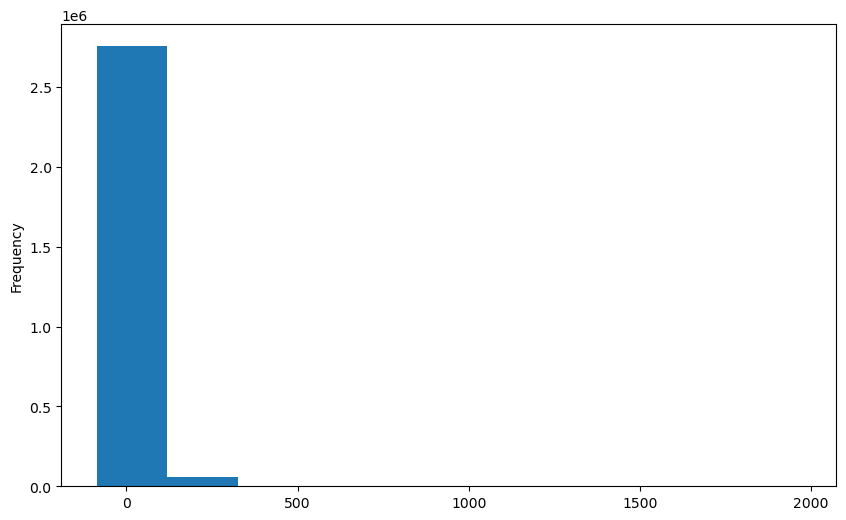

In [106]:
# arrival_delay histogram
flights.arrival_delay.plot.hist()

Analisando o histograma do campo `arrival_delay` podemos logo observar que grande maioria dos valores está concentrada numa região. A este tipo de gráficos costuma-se chamar de long tail distribution.
<br><br> 
Uma maneira de melhor analisar este tipo de gráficos é agrupar todos os valores acima de um determinado percentil, de forma ao histograma criar mais bins na zona que nos interessa analisar.
<br><br>
<div class="alert alert-success">
Q.7<br>
    Sendo <code>p</code> o valor do percentil 95% da coluna <code>arrival_delay</code>.
    <br><br>
    Crie a coluna <code>arrival_delay_copy</code> (cópia da coluna <code>arrival_delay</code>) de forma a que todos os seus valores acima de <code>p</code>, sejam convertidos para <code>p+1</code> e construa um histograma com 20 bins.
    <br><br>
    <span class="badge">Nota:</span> Para alterar um subconjunto de uma coluna do dataframe é aconselhado usar o método <code>loc</code>.
    <br><br>
    <span class="badge">Nota:</span> O método <code>pd.cut</code> poderia ser usado para definir as bins e usava-se um gráfico de barras para simular o histograma. Como?
</div>

<AxesSubplot:ylabel='Frequency'>

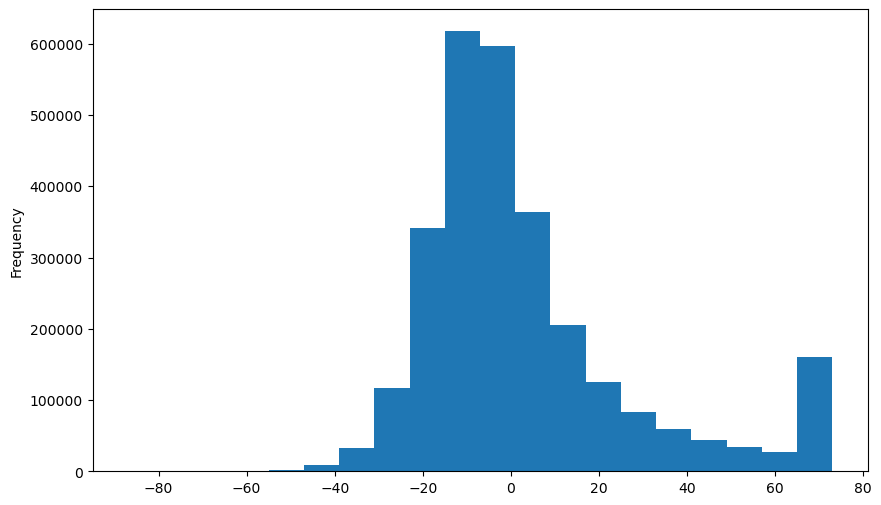

In [107]:
# histogram of arrival delay, where we grouped all values > 95% quantile

flights['arrival_delay_copy'] = flights['arrival_delay'].copy()

#Calcular o percentil 95% da coluna 'arrival_delay'
p = flights['arrival_delay'].quantile(0.95)

# Subtituir os valores acima de p por p + 1 na nova coluna 'arrival_delay_copy'
flights.loc[flights['arrival_delay_copy'] > p ,'arrival_delay_copy'] = p+1

flights['arrival_delay_copy'].plot.hist(bins=20)

In [108]:
flights.head()

,year,month,day,airline,origin_airport,destination_airport,scheduled_departure,departure_delay,scheduled_time,elapsed_time,air_time,distance,arrival_delay,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,is_delayed,arrival_delay_copy
0,2015,1,1,AS,ANC,SEA,5.000,-11.000,205.000,194.000,169.000,1448,-22.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False,-22.000
1,2015,1,1,AA,LAX,PBI,10.000,-8.000,280.000,279.000,263.000,2330,-9.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False,-9.000
2,2015,1,1,US,SFO,CLT,20.000,-2.000,286.000,293.000,266.000,2296,5.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False,5.000
3,2015,1,1,AA,LAX,MIA,20.000,-5.000,285.000,281.000,258.000,2342,-9.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False,-9.000
4,2015,1,1,AS,SEA,ANC,25.000,-1.000,235.000,215.000,199.000,1448,-21.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False,-21.000


Agora percebe-se muito melhor a distribuição desta coluna.

#### 1.2 Análise temporal

Para a nossa análise temporal vamos começar por colocar a data como índice. Assim, temos de ter um campo no formato de data.

<div class="alert alert-success">
Q.8<br>
    Crie a coluna <code>date</code> com a data do voo até ao minuto. Na 1ª parte do trabalho fizemos um exercício parecido, mas nesse o formato final era string e nesta pergunta tem de ser do tipo data.
    <br><br> 
    <span class="badge">Nota: Não se esqueça das funções <code>convert_to_time_format</code> e <code>pd.to_datetime</code></span> 
</div>

In [109]:
# date column
flights['date'] = flights['scheduled_departure'].map(convert_to_time_format)

flights['date'] = flights.apply(lambda row: f"{row['year']}-{row['month']:02d}-{row['day']:02d} {row['date']}", axis=1)

# Converter a coluna date para ser do tipo data
flights['date'] = pd.to_datetime(flights['date'], format = '%Y-%m-%d %H:%M')

flights.head()

,year,month,day,airline,origin_airport,destination_airport,scheduled_departure,departure_delay,scheduled_time,elapsed_time,air_time,distance,arrival_delay,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,is_delayed,arrival_delay_copy,date
0,2015,1,1,AS,ANC,SEA,5.000,-11.000,205.000,194.000,169.000,1448,-22.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False,-22.000,2015-01-01 00:05:00
1,2015,1,1,AA,LAX,PBI,10.000,-8.000,280.000,279.000,263.000,2330,-9.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False,-9.000,2015-01-01 00:10:00
2,2015,1,1,US,SFO,CLT,20.000,-2.000,286.000,293.000,266.000,2296,5.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False,5.000,2015-01-01 00:20:00
3,2015,1,1,AA,LAX,MIA,20.000,-5.000,285.000,281.000,258.000,2342,-9.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False,-9.000,2015-01-01 00:20:00
4,2015,1,1,AS,SEA,ANC,25.000,-1.000,235.000,215.000,199.000,1448,-21.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False,-21.000,2015-01-01 00:25:00


Agora sim, podemos colocar a coluna `date` como índice.

In [110]:
flights.set_index('date', inplace=True, drop=False)
flights.index.names = ['date_index'] # avoid ambiguitiy with column 'date'

In [111]:
flights.head()

,year,month,day,airline,origin_airport,destination_airport,scheduled_departure,departure_delay,scheduled_time,elapsed_time,air_time,distance,arrival_delay,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,is_delayed,arrival_delay_copy,date
date_index,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:05:00,2015,1,1,AS,ANC,SEA,5.000,-11.000,205.000,194.000,169.000,1448,-22.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False,-22.000,2015-01-01 00:05:00
2015-01-01 00:10:00,2015,1,1,AA,LAX,PBI,10.000,-8.000,280.000,279.000,263.000,2330,-9.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False,-9.000,2015-01-01 00:10:00
2015-01-01 00:20:00,2015,1,1,US,SFO,CLT,20.000,-2.000,286.000,293.000,266.000,2296,5.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False,5.000,2015-01-01 00:20:00
2015-01-01 00:20:00,2015,1,1,AA,LAX,MIA,20.000,-5.000,285.000,281.000,258.000,2342,-9.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False,-9.000,2015-01-01 00:20:00
2015-01-01 00:25:00,2015,1,1,AS,SEA,ANC,25.000,-1.000,235.000,215.000,199.000,1448,-21.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False,-21.000,2015-01-01 00:25:00


<div class="alert alert-success">
Q.9<br>
    Para os meses de Janeiro e Fevereiro, mostre um plot com o número de voos por dia.
    <br><br> 
    <span class="badge">Nota:</span> para filtar os meses use slicing de datas no índice (aula 6, secção 1.5)
</div>

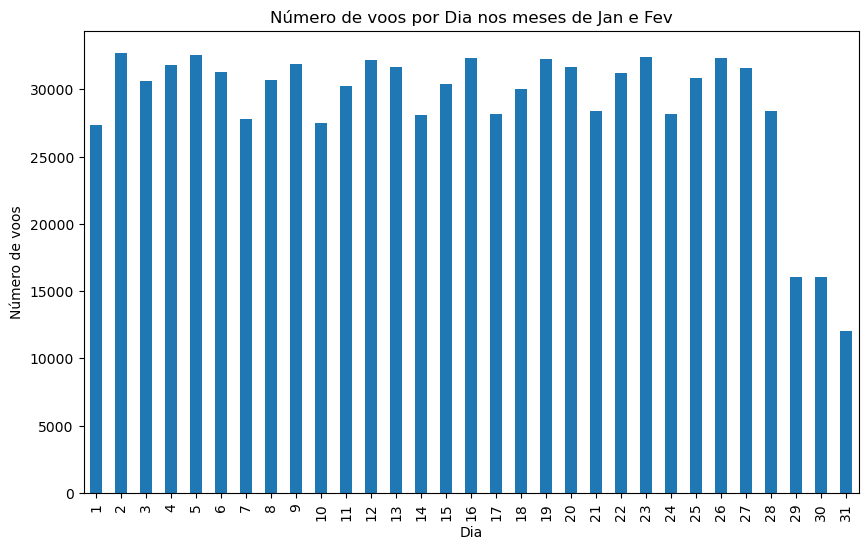

In [112]:
# daily flights 

# Filtrar os dados para os meses de Janeiro e Fevereiro
flights_jan_feb = flights[(flights['month'] == 1) | (flights['month'] == 2)]

# Contar o nº total de voos nos meses de Janeiro e Fevereiro e ordenar os dias
flights_jan_feb_total = flights_jan_feb['date'].dt.day.value_counts().sort_index()

# Construção do gráfico
plt.title('Número de voos por Dia nos meses de Jan e Fev')
plt.xlabel('Dia')
plt.ylabel('Número de voos')
flights_jan_feb_total.plot.bar();

Ao analisar a distribuição do número de voos por dia, podemos observar que parece have periodicidade no decréscimo do número de voos, será o fim de semana?
<br><br>
<div class="alert alert-success">
Q.10 <br>
    Adicione a coluna <code>day_of_week</code> com o dia da semana do ano e mostre um plot com o número de voos por dia da semana (neste já poderemos usar a totalidade dos meses).
</div>

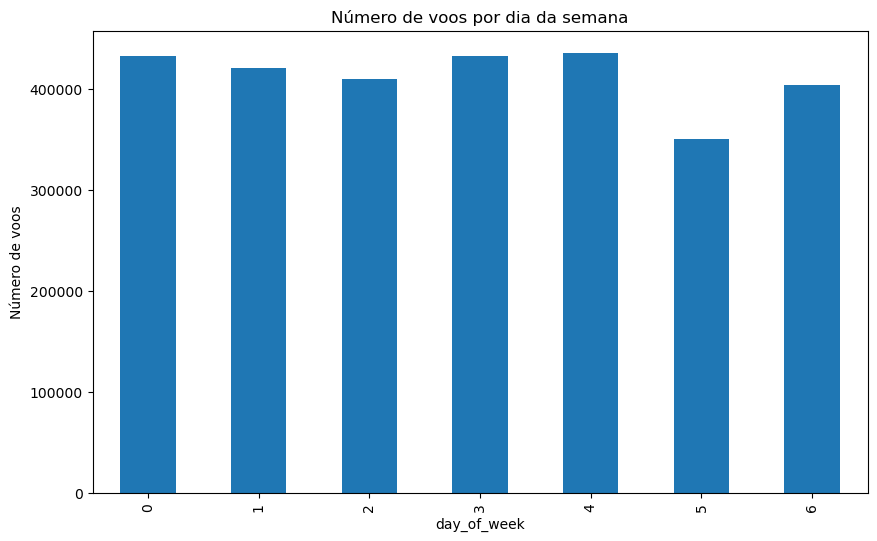

In [113]:
flights['day_of_week'] = flights['date'].dt.dayofweek

# Construção do gráfico
plt.title('Número de voos por dia da semana')
plt.ylabel('Número de voos')
flights.groupby('day_of_week')['is_delayed'].count().plot.bar();

Parece que o dia da semana com menos voos é o sábado!
<br><br>
<div class="alert alert-success">
Q.11<br>
    Transforme o gráfico anterior em percentagem e adicione uma barra com a percentagem de voos atrasados por dia da semana.
</div>

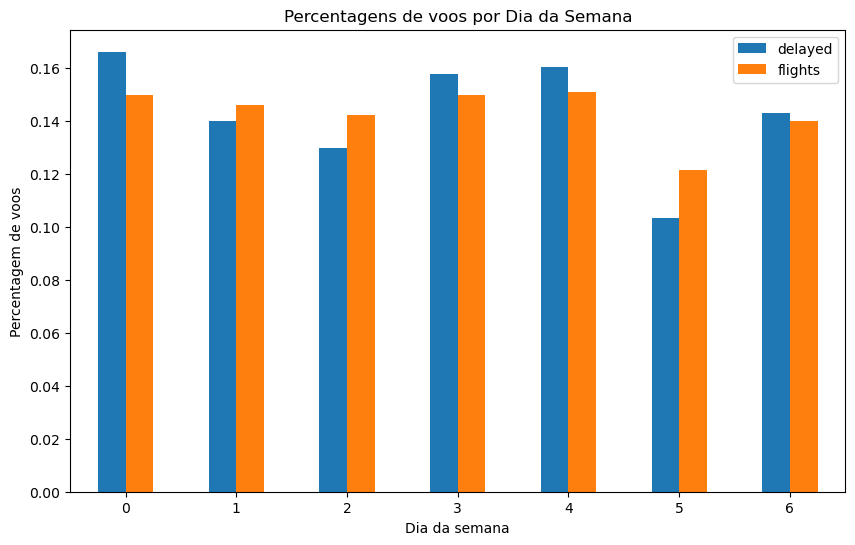

In [114]:
g = flights.groupby('day_of_week')['is_delayed'].agg(['sum','count'])
g.columns = ['delayed', 'flights']

# transfrom g to percentage here
# Flights column
total_flights = g['flights'].sum()
g['flights'] = g['flights']/total_flights
# Delayed flights column
delayed_flights = g['delayed'].sum()
g['delayed'] = g['delayed']/delayed_flights

g.plot.bar()
plt.title('Percentagens de voos por Dia da Semana')
plt.xlabel('Dia da semana')
plt.ylabel('Percentagem de voos')
plt.xticks(rotation = 0)
plt.show();

In [115]:
g

,delayed,flights
day_of_week,,
0,0.166,0.150
1,0.140,0.146
2,0.130,0.142
3,0.158,0.150
4,0.160,0.151
5,0.103,0.121
6,0.143,0.140


<div class="alert alert-success">
Q.12<br>
    Utilizando o método <code>pivot_table</code> construa um dataframe com a percentagem de voos atrasados por airline (índice das colunas) para cada dia da semana (índice das linhas).
</div>

In [116]:
# the pivot_table should have this format
#
# airline        AA    AS    B6    DL    EV    F9    HA    MQ    NK    OO    UA    US    VX    WN
# day_of_week                                                                                    
# 0           0.238 0.134 0.282 0.170 0.238 0.333 0.095 0.277 0.351 0.206 0.252 0.195 0.230 0.212
# 1           0.174 0.110 0.221 0.158 0.213 0.272 0.080 0.249 0.321 0.183 0.222 0.185 0.168 0.182
# 2           0.183 0.110 0.183 0.134 0.212 0.332 0.107 0.243 0.284 0.191 0.202 0.159 0.133 0.174
# 3           0.213 0.128 0.226 0.156 0.220 0.322 0.129 0.264 0.297 0.192 0.254 0.196 0.206 0.215
# 4           0.223 0.145 0.221 0.153 0.210 0.314 0.168 0.281 0.324 0.195 0.240 0.195 0.215 0.222
# 5           0.191 0.110 0.204 0.121 0.167 0.287 0.129 0.194 0.296 0.152 0.200 0.167 0.120 0.165
# 6           0.218 0.138 0.231 0.137 0.213 0.314 0.089 0.255 0.340 0.199 0.237 0.186 0.232 0.205

flights_pivot_table = flights.pivot_table(values = 'is_delayed', index ='day_of_week', columns ='airline', aggfunc='mean')

flights_pivot_table

airline,AA,AS,B6,DL,EV,F9,HA,MQ,NK,OO,UA,US,VX,WN
day_of_week,,,,,,,,,,,,,,
0,0.238,0.134,0.282,0.170,0.238,0.333,0.095,0.277,0.351,0.206,0.252,0.195,0.230,0.212
1,0.174,0.110,0.221,0.158,0.213,0.272,0.080,0.249,0.321,0.183,0.222,0.185,0.168,0.182
2,0.183,0.110,0.183,0.134,0.212,0.332,0.107,0.243,0.284,0.191,0.202,0.159,0.133,0.174
3,0.213,0.128,0.226,0.156,0.220,0.322,0.129,0.264,0.297,0.192,0.254,0.196,0.206,0.215
4,0.223,0.145,0.221,0.153,0.210,0.314,0.168,0.281,0.324,0.195,0.240,0.195,0.215,0.222
5,0.191,0.110,0.204,0.121,0.167,0.287,0.129,0.194,0.296,0.152,0.200,0.167,0.120,0.165
6,0.218,0.138,0.231,0.137,0.213,0.314,0.089,0.255,0.340,0.199,0.237,0.186,0.232,0.205


#### 1.3 Considerando informação de contexto

A informação de contexto que será usada é a presente no dataframe `airports`, pois podemos adicionar várias informações úteis relativas aos aeroportos de partida e chegada do voo.
<br><br>
<div class="alert alert-success">
Q.13<br>
    Crie o dataframe <code>flights_context_info</code> com base no dataframe <code>flights</code> onde se adiciona todas as colunas do dataframe <code>airports</code> como informação de contexto para a coluna <code>origin_airpot</code>. Adicione também a mesma informação de contexto para a coluna <code>destination_airport</code>.
</div>

In [117]:
# selecting necessary fields
airports = airports[['iata_code', 'city', 'state']]

flights_tmp = flights.merge(airports, left_on='origin_airport', right_on='iata_code')
flights_context_info = flights_tmp.merge(airports, left_on='destination_airport', right_on='iata_code', suffixes=('_origin', '_destination'))

flights_tmp.head()
flights_context_info.head()

# free up RAM
#del flights_tmp

,year,month,day,airline,origin_airport,destination_airport,scheduled_departure,departure_delay,scheduled_time,elapsed_time,air_time,distance,arrival_delay,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,is_delayed,arrival_delay_copy,date,day_of_week,iata_code_origin,city_origin,state_origin,iata_code_destination,city_destination,state_destination
0,2015,1,1,AS,ANC,SEA,5.000,-11.000,205.000,194.000,169.000,1448,-22.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False,-22.000,2015-01-01 00:05:00,3,ANC,Anchorage,AK,SEA,Seattle,WA
1,2015,1,1,AS,ANC,SEA,45.000,-4.000,204.000,194.000,173.000,1448,-14.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False,-14.000,2015-01-01 00:45:00,3,ANC,Anchorage,AK,SEA,Seattle,WA
2,2015,1,1,DL,ANC,SEA,45.000,-14.000,210.000,200.000,171.000,1448,-24.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False,-24.000,2015-01-01 00:45:00,3,ANC,Anchorage,AK,SEA,Seattle,WA
3,2015,1,1,AS,ANC,SEA,135.000,NaN,205.000,NaN,NaN,1448,NaN,True,A,NaN,NaN,NaN,NaN,NaN,False,NaN,2015-01-01 01:35:00,3,ANC,Anchorage,AK,SEA,Seattle,WA
4,2015,1,1,AS,ANC,SEA,155.000,-15.000,218.000,198.000,170.000,1448,-35.000,False,NaN,NaN,NaN,NaN,NaN,NaN,False,-35.000,2015-01-01 01:55:00,3,ANC,Anchorage,AK,SEA,Seattle,WA


<div class="alert alert-success">
Q.14<br>
    Calcule o top-10 dos pares (cidades de origem, cidade de destino) com mais voos atrasados (em valor absoluto).
</div>

In [118]:
flights_context_info['ori-dst'] = flights_context_info['city_origin'] + '-' + flights_context_info['city_destination']
flights_context_info.groupby('ori-dst')['is_delayed'].sum().sort_values(ascending=False).head(10)

ori-dst
Chicago-New York             1972
Boston-New York              1925
New York-Boston              1895
New York-Chicago             1728
Los Angeles-San Francisco    1653
San Francisco-Los Angeles    1569
Miami-New York               1560
Chicago-Minneapolis          1508
Ft. Lauderdale-New York      1442
Atlanta-New York             1432
Name: is_delayed, dtype: int64

___
### 2. Gerar dataset histórico, de treino e de teste
___

#### 2.1 Motivação

Normalmente os dados são divididos aleatoriamente nos conjuntos de treino, validação e teste. Contudo, esta abordagem não funciona em alguns domínios devido a uma dependência temporal dos dados. Neste exemplo, o avião `X` pode-se atrasar no voo `Y` devido a um voo anterior `Z`. Assim sendo, não podemos dividir o dataset tal que o voo `Z` vá para treino e o `Y` para teste.
<br><br>
Dessa forma iremos usar Jan e Feb como dataset histórico, Mar e Abr para treino e Mai e Jun para testes. Não estamos a criar um dataset de validação, porquê?

#### 2.2 Construção dos datasets

<div class="alert alert-success">
    Q.15<br>
    Com base nas especificações de 2.1 construa os datasets.
</div>

In [119]:
hist = flights_context_info[(flights_context_info['month'] == 1) | (flights_context_info['month'] == 2)].copy().reset_index(drop=True)
train = flights_context_info[(flights_context_info['month'] == 3) | (flights_context_info['month'] == 4)].copy().reset_index(drop=True)
test = flights_context_info[(flights_context_info['month'] == 5) | (flights_context_info['month'] == 6)].copy().reset_index(drop=True)

print(len(hist))
print(len(train))
print(len(test))

# confirm number of rows per dataset
assert len(hist) == 899159
assert len(train) == 989463
assert len(test) == 1000890

899159
989463
1000890


___
### 3. Feature Engineering
___

Neste momento terminámos o DU e contruímos os conjuntos de treino e teste. Ou seja, estamos preparados para adicionar features (novas colunas) e testar o nosso modelo.
<br><br>
Mas antes vamos remover de memória toda a informação (dataframes e outras variáveis) que já não iremos necessitar.

In [120]:
for c in 'airlines airports flights columns_to_remove columns delays g p flights_context_info total_delay'.split():
    if c in globals():
        del globals()[c] 

#### 3.1 Usando dados históricos

A ideia do dataset histório é para nos permitir adicionar features ao conjunto de treino e teste, como a percentagem de voos atrasados daquela companhia aérea, usando apenas informação do passado.

<div class="alert alert-success">
Q.16<br>
    Com base nos dados históricos, adicione a coluna <code>perc_delayed_flights_airline</code> ao treino e teste com a percentagem de voos atrasados da companhia aérea.
</div>

In [121]:
mapping = hist.groupby('airline')['is_delayed'].mean().to_dict()

train['perc_delayed_flights_airline'] = train['airline'].map(mapping)
test['perc_delayed_flights_airline'] = test['airline'].map(mapping)

#train.head()
#test.tail()

<div class="alert alert-success">
Q.17<br>
    Com base nos dados históricos, adicione a coluna <code>perc_delayed_flights_route</code> ao treino e teste com a percentagem de voos atrasados por par (cidade de origem, cidade de destino).
</div>

In [122]:
mapping = hist.groupby('ori-dst')['is_delayed'].mean().to_dict()

train['perc_delayed_flights_route'] = train['ori-dst'].map(mapping)
test['perc_delayed_flights_route'] = test['ori-dst'].map(mapping)

#train.head()
#test.tail()

<div class="alert alert-success">
Q.18<br>
    Por fim, com base nos dados históricos, adicione as colunas <code>avg_delay_city</code> e <code>avg_delay_airline</code> ao treino e teste com a média de atraso dos voos da cidade de origem e da airline, respectivamente.
</div>

In [123]:
# Avg_delay_city
mapping_city = hist.groupby('city_origin')['is_delayed'].mean().to_dict()
train['avg_delay_city'] = train['city_origin'].map(mapping_city)
test['avg_delay_city'] = test['city_origin'].map(mapping_city)

# Avg_delay_airline
mapping_airline = hist.groupby('airline')['is_delayed'].mean().to_dict()
train['avg_delay_airline'] = train['airline'].map(mapping_airline)
test['avg_delay_airline'] = test['airline'].map(mapping_airline)

print("Train:")
print(train.head())
print("Test:")
print(test.head())


Train:
   year  month  day airline origin_airport destination_airport  \
0  2015      3    1      AS            ANC                 SEA   
1  2015      3    1      AS            ANC                 SEA   
2  2015      3    1      AS            ANC                 SEA   
3  2015      3    1      AS            ANC                 SEA   
4  2015      3    1      DL            ANC                 SEA   

   scheduled_departure  departure_delay  scheduled_time  elapsed_time  \
0                5.000           27.000         202.000       182.000   
1               45.000           20.000         200.000       179.000   
2              215.000            0.000         198.000       178.000   
3              505.000            4.000         199.000       185.000   
4              610.000           -4.000         209.000       205.000   

   air_time  distance  arrival_delay  cancelled cancellation_reason  \
0   161.000      1448          7.000      False                 NaN   
1   152.000    

#### 3.2 Novos campos temporais

<div class="alert alert-success">
Q.19<br>
    Como já temos uma coluna com o dia da semana, iremos apenas adicionar as seguintes colunas ao treino e teste:
    <ul>
        <li><code>is_weekend</code>: 1, se o dia da semana for 5 ou 6, 0 caso contrário</li>
        <li><code>is_monday</code>: 1, se o dia da semana for 0, 0 caso contrário</li>
        <li><code>is_saturday</code>: 1, se o dia da semana for 5, 0 caso contrário</li>
    </ul>
</div>

In [124]:
def add_temporal_features(df):
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['is_monday'] = df['day_of_week'].isin([0]).astype(int)
    df['is_saturday'] = df['day_of_week'].isin([5]).astype(int)
    
    return df

add_temporal_features(train)
add_temporal_features(test)

print('Train:')
print(train[['day_of_week', 'is_weekend', 'is_monday', 'is_saturday']])

print('Test:')
print(test[['day_of_week', 'is_weekend', 'is_monday', 'is_saturday']])

Train:
        day_of_week  is_weekend  is_monday  is_saturday
0                 6           1          0            0
1                 6           1          0            0
2                 6           1          0            0
3                 6           1          0            0
4                 6           1          0            0
...             ...         ...        ...          ...
989458            6           1          0            0
989459            0           0          1            0
989460            1           0          0            0
989461            2           0          0            0
989462            3           0          0            0

[989463 rows x 4 columns]
Test:
         day_of_week  is_weekend  is_monday  is_saturday
0                  4           0          0            0
1                  4           0          0            0
2                  4           0          0            0
3                  4           0          0            0
4  

In [125]:
train['airline']

0         AS
1         AS
2         AS
3         AS
4         DL
          ..
989458    AS
989459    AS
989460    AS
989461    AS
989462    AS
Name: airline, Length: 989463, dtype: category
Categories (14, object): ['AA', 'AS', 'B6', 'DL', ..., 'UA', 'US', 'VX', 'WN']

#### 3.3 Risky features e OHE

<div class="alert alert-success">
    Q.20<br>
    Adicione a coluna <code>is_risky_airline</code> que terá o valor 1 caso a companhia aérea for <code>NK, F9, MQ ou EV</code> e 0 caso contrário, ao treino e teste.
</div>

In [126]:
# Criar uma lista que contém as companhias aéreas em risco 
risky_airlines = ['NK', 'F9', 'MQ', 'EV']
# Conjunto de treino
train['is_risky_airline'] = train['airline'].apply(lambda x: 1 if x in risky_airlines else 0)
# Conjunto de teste
test['is_risky_airline'] = test['airline'].apply(lambda x: 1 if x in risky_airlines else 0)

print('Train:')
print(train['is_risky_airline'].value_counts())
print('Test:')
print(test['is_risky_airline'].value_counts())

Train:
0    799142
1    190321
Name: is_risky_airline, dtype: int64
Test:
0    815832
1    185058
Name: is_risky_airline, dtype: int64


<div class="alert alert-success">
Q.21<br>
    Adicione a coluna <code>is_risky_city</code> que terá o valor 1 caso a cidade de origem ou a cidade de destino for <code>New York, Boston, Chicago, San Francisco, Los Angeles ou Atlanta</code> e 0 caso contrário, ao treino e teste.
</div>

A função <code>my_is_risky_city</code> terá de ser usada para se comparar strings ignorando maiúsculas e espaços.

In [127]:
risky_cities = 'newyork boston chicago sanfrancisco losangeles atlanta'.split()

def my_is_risky_city(city):
    return city.replace(' ', '').lower() in risky_cities

train['is_risky_city'] = train.apply(lambda x: 1 if my_is_risky_city(x['city_origin']) or my_is_risky_city(x['city_destination'])  else 0, axis = 1)
test['is_risky_city'] = test.apply(lambda x: 1 if my_is_risky_city(x['city_origin']) or my_is_risky_city(x['city_destination'])  else 0, axis = 1)

In [128]:
print(train['is_risky_city'].value_counts())

print(test['is_risky_city'].value_counts())

0    535545
1    453918
Name: is_risky_city, dtype: int64
0    537914
1    462976
Name: is_risky_city, dtype: int64


In [129]:
print("Train length before:", len(train))
print("Test length before:", len(test))

Train length before: 989463
Test length before: 1000890


<div class="alert alert-success">
Q.22<br>
    Utilizando a função <code>apply_ohe</code> da primeira parte do trabalho ou adicionando manualmente as colunas. 
    <br><br>
    Adicione, com base nos dados históricos, o OHE do top-5 de aeroportos de partida com mais voos atrasados, ao treino e teste.
</div>

In [130]:
categories_ohe = hist.groupby('origin_airport')['is_delayed'].mean().sort_values(ascending=False).head(5).index.values

def apply_ohe(df, column, categories):
   
    for category in categories: 
        
        df[column + '_' + str(category)] = (df[column].apply(lambda x: int(x == category)))
    
    return df

# apply OHE in train and test
train = apply_ohe(train, 'origin_airport', categories_ohe)
test = apply_ohe(test, 'origin_airport', categories_ohe)

print(train.head())
print(test.head())

   year  month  day airline origin_airport destination_airport  \
0  2015      3    1      AS            ANC                 SEA   
1  2015      3    1      AS            ANC                 SEA   
2  2015      3    1      AS            ANC                 SEA   
3  2015      3    1      AS            ANC                 SEA   
4  2015      3    1      DL            ANC                 SEA   

   scheduled_departure  departure_delay  scheduled_time  elapsed_time  \
0                5.000           27.000         202.000       182.000   
1               45.000           20.000         200.000       179.000   
2              215.000            0.000         198.000       178.000   
3              505.000            4.000         199.000       185.000   
4              610.000           -4.000         209.000       205.000   

   air_time  distance  arrival_delay  cancelled cancellation_reason  \
0   161.000      1448          7.000      False                 NaN   
1   152.000      1448 

In [131]:
print("Train length after:", len(train))
print("Test length after:", len(test))

Train length after: 989463
Test length after: 1000890


In [132]:
print('Train:')
print(train['origin_airport_PPG'].value_counts())
print(train['origin_airport_TTN'].value_counts())
print(train['origin_airport_OTH'].value_counts())
print(train['origin_airport_COU'].value_counts())
print(train['origin_airport_PBG'].value_counts())
print('Test:')
print(test['origin_airport_PPG'].value_counts())
print(test['origin_airport_TTN'].value_counts())
print(test['origin_airport_OTH'].value_counts())
print(test['origin_airport_COU'].value_counts())
print(test['origin_airport_PBG'].value_counts())

Train:
0    989446
1        17
Name: origin_airport_PPG, dtype: int64
0    988999
1       464
Name: origin_airport_TTN, dtype: int64
0    989428
1        35
Name: origin_airport_OTH, dtype: int64
0    989223
1       240
Name: origin_airport_COU, dtype: int64
0    989406
1        57
Name: origin_airport_PBG, dtype: int64
Test:
0    1000870
1         20
Name: origin_airport_PPG, dtype: int64
0    1000341
1        549
Name: origin_airport_TTN, dtype: int64
0    1000840
1         50
Name: origin_airport_OTH, dtype: int64
0    1000656
1        234
Name: origin_airport_COU, dtype: int64
0    1000847
1         43
Name: origin_airport_PBG, dtype: int64


#### 3.4 Normalizar colunas

<div class="alert alert-success">
Q.23<br>
    Com base na média e desvio padrão da coluna <code>distance</code> dos dados históricos, adicione a coluna <code>distance_normalized</code> com a utilização da normalização <code>z_score</code> na coluna <code>distance</code>.
</div>

In [133]:
def z_score(df, column, mean, std):
    return (df[column] - mean)/ std

mean = hist['distance'].mean()
std = hist['distance'].std()
train['distance_normalized'] = z_score(train, 'distance', mean, std)
test['distance_normalized'] = z_score(test, 'distance', mean, std)

<AxesSubplot:ylabel='Frequency'>

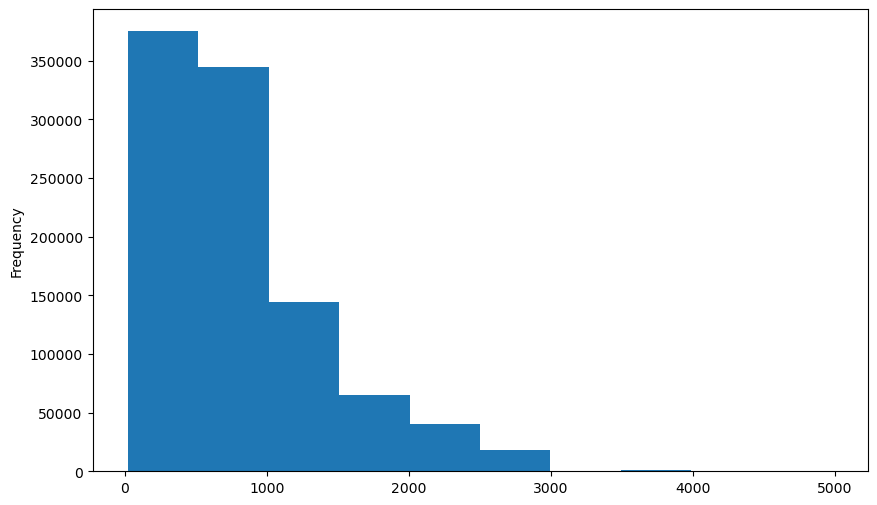

In [134]:
train.distance.plot.hist()

<AxesSubplot:ylabel='Frequency'>

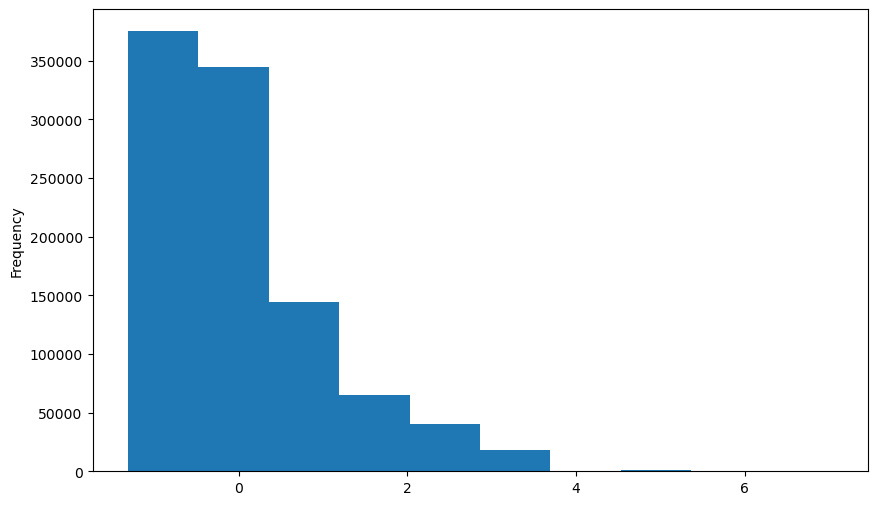

In [135]:
train.distance_normalized.plot.hist()

#### 3.5 Outras colunas

<div class="alert alert-warning">
Q.24<br>
    Esta secção é opcional.
    <br><br>
    Adicione outras features que pense serem preditivas na identificação de atrasos em voos.
</div>

#### 3.6 Remover colunas desnecessárias

Neste momento temos imensas colunas ou que não podem ser usadas para treinar o modelo (p.e. `arrival_delay`) ou que não fazem sentido usar (p.e. `year`) ou porque o modelo não suporta (p.e. colunas do tipo string). Assim vamos remover todas as colunas desnecessárias.

In [136]:
ohe = ['origin_airport_%s' % categ for categ in categories_ohe]

columns_to_keep = 'is_delayed day_of_week departure_delay scheduled_departure scheduled_time perc_delayed_flights_airline perc_delayed_flights_route avg_delay_city avg_delay_airline is_weekend is_monday is_saturday is_risky_airline is_risky_city distance_normalized'.split()
columns_to_keep.extend(ohe)

# remove all columns that are not numbers
for ds in [train, test]:
    to_remove = ds[columns_to_keep].select_dtypes('object').columns
    for col in to_remove:
        columns_to_keep.remove(col)

train = train[columns_to_keep].copy()
test = test[columns_to_keep].copy()

Por fim podemos analisar a correlação entre as features de forma a removermos features correlacionadas

In [137]:
train2 = train.copy()
train2['perc_delayed_flights_airline'] = train2['perc_delayed_flights_airline'].astype(float)
train2['avg_delay_airline'] = train2['avg_delay_airline'].astype(float)
corr = train2.corr()

# all entries with correlation below 0.9 will display nan
corr[(corr >= 0.9) | (corr <= -0.9)]

,is_delayed,day_of_week,departure_delay,scheduled_departure,scheduled_time,perc_delayed_flights_airline,perc_delayed_flights_route,avg_delay_city,avg_delay_airline,is_weekend,is_monday,is_saturday,is_risky_airline,is_risky_city,distance_normalized,origin_airport_PPG,origin_airport_TTN,origin_airport_OTH,origin_airport_COU,origin_airport_PBG
is_delayed,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_of_week,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
departure_delay,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scheduled_departure,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scheduled_time,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.982,NaN,NaN,NaN,NaN,NaN
perc_delayed_flights_airline,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
perc_delayed_flights_route,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_delay_city,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_delay_airline,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_weekend,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Podemos observar que as features `avg_delay_airline` e `perc_delayed_flights_airline` têm correlação elevada e faz sentido, uma vez que estão a representar informação muito idêntica.
<br><br>
Os campos `distance_normalized` e `scheduled_time` também têm correlação elevada, contudo tal já não é tão claro. Será que os voos com maior distência são de noite?

___
### 4. Construir regressão logística
___

Antes de começar a treinar o modelo, vamos converter a coluna `is_delayed` para o tipo numérico (requisito da regressão linear).

In [138]:
train['is_delayed'] = train['is_delayed'].astype(int)
test['is_delayed'] = test['is_delayed'].astype(int)

Vamos converter colunas que têm o formato categorico erradamente.

In [139]:
for col in 'perc_delayed_flights_airline avg_delay_airline'.split():
    train[col] = train[col].astype(float)
    test[col] = test[col].astype(float)

Tratar os NaNs. Neste caso estamos a substituir todos os NaNs por 0.

In [140]:
for c in train.isnull().sum()[lambda x: x>0].index:
    train[c].fillna(0, inplace=True)
    
for c in test.isnull().sum()[lambda x: x>0].index:
    test[c].fillna(0, inplace=True)

#### 4.1 Treino do modelo

In [141]:
from sklearn.linear_model import LogisticRegression

# build features set
features = train.columns.drop('is_delayed')

# train logistic regression to predic is_delayed 
model = LogisticRegression(max_iter=1000)
train_results = model.fit(train[features], train['is_delayed'])

# use trained model to predit is_delayed field in test set
test_results = model.predict(test[features])

#### 4.2 Construir matriz de confusão

In [142]:
confusion_matrix = pd.crosstab(test['is_delayed'], test_results)
confusion_matrix.columns = ['predicted_not_delay', 'predicted_delay']
confusion_matrix.index = ['actual_not_delay', 'actual_delay']

In [143]:
print(confusion_matrix)

                  predicted_not_delay  predicted_delay
actual_not_delay               780960            14543
actual_delay                    56545           148842


#### 4.3 Avaliar performance do modelo

<div class="alert alert-success">
Q.25<br>
    Com base na matriz de confusão calcule o accuracy (definição <a href="https://en.wikipedia.org/wiki/Precision_and_recall">aqui</a>). Notar que classe positiva é a de voos com atraso.
</div>

In [144]:
tp = confusion_matrix.loc['actual_delay', 'predicted_delay']
fp = confusion_matrix.loc['actual_not_delay', 'predicted_delay']
tn = confusion_matrix.loc['actual_not_delay', 'predicted_not_delay']
fn = confusion_matrix.loc['actual_delay', 'predicted_not_delay']

acc = (tp + tn) / (tp + tn + fp + fn) 
print(f'Accuracy is: {acc}')

Accuracy is: 0.9289752120612654
